In [23]:
import json
import re
import os
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
import random



# 停用词设计

In [24]:
# 创建结果目录
os.makedirs('final_results/topics', exist_ok=True)
os.makedirs('final_results/visualizations', exist_ok=True)

# 下载必要的NLTK资源
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('stopwords', quiet=True)

# 读取数据
with open('reddit_insurance_reviews.json', 'r', encoding='utf-8') as f:
    posts = json.load(f)

# 定义保险公司列表
companies = ['Sun Life', 'Prudential', 'AXA', 'AIA', 'Manulife']

# 定义复合词列表 - 增加更多商业相关的复合词
compound_words = [
    'hong kong', 'new york', 'san francisco', 'los angeles', 'united states',
    'great britain', 'south africa', 'north america', 'south america', 'latin america',
    'middle east', 'united kingdom', 'european union', 'bay area', 'silicon valley',
    'wall street', 'health insurance', 'life insurance', 'car insurance', 'home insurance',
    'travel insurance', 'cyber insurance', 'property insurance', 'liability insurance',
    'disability insurance', 'long term care', 'term life', 'whole life', 'universal life',
    'variable life', 'indexed universal life', 'group insurance', 'individual insurance',
    'critical illness', 'accidental death', 'cash value', 'premium payment', 'death benefit',
    'living benefit', 'surrender value', 'policy loan', 'insurance agent', 'insurance broker',
    'financial advisor', 'customer service', 'claim process', 'underwriting process',
    'medical exam', 'risk assessment', 'policy renewal', 'policy cancellation', 'tax benefit',
    'retirement planning', 'estate planning', 'wealth management', 'financial planning',
    'investment strategy', 'asset allocation', 'portfolio management', 'market volatility',
    'interest rate', 'dividend payment', 'guaranteed return', 'variable return', 'annual return',
    'compound interest', 'dollar cost averaging', 'lump sum', 'monthly premium', 'annual premium',
    'premium waiver', 'grace period', 'waiting period', 'exclusion period', 'coverage limit',
    'deductible amount', 'copayment requirement', 'out of pocket', 'in network', 'out of network',
    # 添加更多商业价值相关的复合词
    'customer satisfaction', 'customer experience', 'customer loyalty', 'customer retention',
    'market share', 'competitive advantage', 'value proposition', 'brand reputation',
    'brand image', 'brand loyalty', 'brand awareness', 'brand equity', 'brand value',
    'digital transformation', 'digital strategy', 'digital marketing', 'social media',
    'online presence', 'mobile app', 'user interface', 'user experience', 'customer journey',
    'sales process', 'sales funnel', 'lead generation', 'conversion rate', 'customer acquisition',
    'customer lifetime value', 'churn rate', 'retention rate', 'net promoter score',
    'customer feedback', 'customer complaint', 'customer review', 'customer rating',
    'price sensitivity', 'price elasticity', 'price comparison', 'price transparency',
    'cost efficiency', 'cost reduction', 'cost optimization', 'operational efficiency',
    'process improvement', 'quality control', 'quality assurance', 'service level',
    'response time', 'resolution time', 'first call resolution', 'call center',
    'distribution channel', 'sales channel', 'channel strategy', 'omnichannel',
    'market penetration', 'market development', 'product development', 'diversification',
    'competitive analysis', 'swot analysis', 'pest analysis', 'porter five forces',
    'business model', 'revenue model', 'profit margin', 'return on investment',
    'cash flow', 'financial performance', 'financial health', 'financial stability'
]

# 进一步增强的停用词列表 - 根据用户反馈优化
english_stopwords = set(stopwords.words('english'))

# 强制停用词列表 - 包含通用词、时间相关词汇和公司名称
forced_stopwords = set([
    # 通用词汇 - 根据用户反馈移除
    'insurance', 'company', 'insurer', 'insured', 'insure', 'customer', 'thing',
    
    # 时间相关词汇
    'people', 'person', 'year', 'month', 'day', 'week', 'hour', 'minute', 'second', 
    'today', 'tomorrow', 'yesterday', 'morning', 'afternoon', 'evening', 'night',
    'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
    'january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september',
    'october', 'november', 'december', 'time', 'date', 'period', 'duration',
    
    # 公司名称及其变体
    'sun', 'life', 'sunlife', 'sun life', 'prudential', 'pru', 'axa', 'aia', 
    'manulife', 'manu', 'metlife', 'met', 'allianz', 'aviva', 'cigna', 'zurich',
    'liberty', 'mutual', 'nationwide', 'allstate', 'geico', 'progressive', 'state farm',
    'farmers', 'travelers', 'usaa', 'hartford', 'chubb', 'aflac', 'unum', 'lincoln',
    'guardian', 'principal', 'transamerica', 'pacific', 'american', 'national', 'mutual',
    
    # 基本停用词
    'com', 'http', 'www', 'said', 'would', 'could', 'one', 'get', 'got', 'say', 'told', 'may', 'new',
    'like', 'call', 'back', 'still', 'know', 'even', 'thing', 'way', 'need',
    'make', 'take', 'help', 'someone', 'something', 'many', 'come', 'much', 'go',
    'see', 'user', 'us', 'use', 'co', 'really', 'amp', 'etc', 'org', 'just',
    'yet', 'another', 'always', 'however', 'well', 'since', 'though', 'already', 'day',
    
    # 常见动词和形容词
    'want', 'look', 'find', 'give', 'try', 'ask', 'tell', 'talk', 'think', 'feel', 'seem',
    'come', 'leave', 'put', 'mean', 'keep', 'let', 'begin', 'start', 'stop', 'end',
    'first', 'last', 'next', 'previous', 'now', 'later', 'soon', 'early', 'late',
    'high', 'low', 'big', 'small', 'large', 'little', 'long', 'short', 'old', 'new',
    'good', 'bad', 'better', 'best', 'worse', 'worst', 'great', 'nice', 'fine', 'right',
    'wrong', 'sure', 'able', 'free', 'full', 'every', 'each', 'all', 'any', 'some',
    
    # 常见助词和连词
    'lot', 'bit', 'well', 'might', 'may', 'would', 'could', 'should', 'must', 'will',
    'shall', 'can', 'cannot', 'cant', 'wont', 'dont', 'doesnt', 'didnt', 'isnt', 'arent',
    'wasnt', 'werent', 'hasnt', 'havent', 'hadnt', 'couldnt', 'wouldnt', 'shouldnt',
    'yes', 'no', 'not', 'never', 'ever', 'always', 'sometimes', 'often', 'rarely',
    'seldom', 'usually', 'normally', 'generally', 'typically', 'basically', 'actually',
    'really', 'truly', 'simply', 'just', 'only', 'even', 'still', 'also', 'too',
    'very', 'quite', 'rather', 'pretty', 'somewhat', 'somehow', 'anyway', 'anyhow',
    'however', 'whatever', 'whenever', 'wherever', 'whoever', 'whichever', 'moreover',
    'furthermore', 'addition', 'besides', 'instead', 'otherwise', 'therefore', 'thus',
    'hence', 'consequently', 'accordingly', 'meanwhile', 'nonetheless', 'nevertheless',
    'although', 'though', 'despite', 'inspite', 'except', 'unless', 'without', 'beyond',
    'throughout', 'within', 'during', 'while', 'until', 'after', 'before', 'when',
    'where', 'why', 'how', 'what', 'which', 'who', 'whom', 'whose', 'whether',
    
    # 缩写和代词
    'thats', 'theyre', 'youre', 'weve', 'youve', 'theyve', 'ive', 'hes', 'shes',
    'its', 'were', 'they', 'them', 'their', 'there', 'these', 'those', 'this', 'that',
    'here', 'there', 'now', 'then', 'today', 'tonight', 'tomorrow', 'yesterday',
    
    # 用户指出的额外无意义词汇
    'likely', 'actively', 'thanks', 'thank', 'made', 'number', 'address', 'option',
    'direct', 'renewable', 'face', 'point', 'sign', 'max', 'bought', 'based', 'offer',
    'individual', 'check', 'application', 'question', 'condition', 'city', 'state', 'country',
    'report', 'dropped', 'notice', 'advice', 'emergency', 'protect', 'amount', 'bought',
    'young', 'husband', 'wife', 'family', 'child', 'children', 'parent', 'friend', 'age',
    'status', 'rate', 'accumulation', 'product', 'need', 'issue', 'lapse', 'platform',
    'process', 'experience', 'data', 'fund', 'growth', 'investment', 'market', 'paid',
    'premium', 'benefit', 'cover', 'carrier', 'employer', 'employee', 'group', 'fmla',
    'income', 'money', 'cash', 'value', 'tax', 'dividend', 'illustration', 'bpi', 'yr',
    'vietnam', 'india', 'singapore', 'china', 'mainland', 'bank', 'financial', 'client',
    'anxiety', 'dentist', 'renter', 'cyber', 'solution'
])

# 保留词列表 - 根据用户反馈保留的关键词
preserved_words = set([
    'policy', 'claim'  # 用户明确要求保留这两个词
])

# 合并停用词列表，但排除保留词
enhanced_stopwords = english_stopwords.union(forced_stopwords) - preserved_words

# 商业价值相关词汇 - 这些词汇将被保留，不会被过滤掉
business_value_terms = set([
    'service', 'price', 'cost', 'quality', 'satisfaction',
    'complaint', 'review', 'rating', 'recommend', 'referral', 'loyal', 'retention',
    'claim', 'policy', 'efficient', 'quick', 'slow', 'delay', 'response', 'resolution',
    'problem', 'issue', 'solution', 'helpful', 'unhelpful', 'friendly', 'unfriendly',
    'professional', 'unprofessional', 'knowledgeable', 'competent', 'incompetent',
    'reliable', 'unreliable', 'trust', 'distrust', 'honest', 'dishonest', 'transparent',
    'unclear', 'confusing', 'simple', 'complicated', 'easy', 'difficult', 'convenient',
    'inconvenient', 'accessible', 'inaccessible', 'available', 'unavailable',
    'coverage', 'premium', 'payment', 'fee', 'charge', 'discount',
    'expensive', 'cheap', 'affordable', 'unaffordable', 'worth', 'worthless',
    'competitive', 'uncompetitive', 'advantage', 'disadvantage', 'strength', 'weakness',
    'opportunity', 'threat', 'industry', 'sector', 'competitor', 'competition',
    'strategy', 'tactic', 'plan', 'goal', 'objective', 'target', 'performance', 'result',
    'success', 'failure', 'growth', 'decline', 'increase', 'decrease', 'improve', 'worsen',
    'innovation', 'technology', 'digital', 'online', 'mobile', 'app', 'website', 'portal',
    'interface', 'design', 'feature', 'function', 'capability', 'limitation',
    'communication', 'information', 'analytics', 'insight', 'intelligence',
    'decision', 'choice', 'option', 'alternative', 'preference', 'priority',
    'brand', 'reputation', 'image', 'perception', 'awareness', 'recognition',
    'marketing', 'advertising', 'promotion', 'campaign', 'message', 'media',
    'sales', 'revenue', 'profit', 'loss', 'margin', 'return', 'investment',
    'fiscal', 'economic', 'budget', 'forecast', 'projection',
    'risk', 'security', 'safety', 'protection', 'compliance', 'regulation', 'legal',
    'ethical', 'social', 'environmental', 'sustainable', 'responsible', 'corporate',
    'leadership', 'management', 'executive', 'board', 'director', 'officer',
    'staff', 'team', 'culture', 'mission', 'vision', 'purpose'
])

# 文本预处理

In [25]:
# 预处理文本的函数
def preprocess_text(text):
    if not isinstance(text, str):
        return []
    
    # 转换为小写
    text = text.lower()
    
    # 替换复合词中的空格为下划线，以便将它们视为单个词
    for compound in compound_words:
        text = text.replace(compound, compound.replace(' ', '_'))
    
    # 移除特殊字符和数字
    text = re.sub(r'[^a-zA-Z\s_]', '', text)
    
    # 分词 (使用简单的空格分词)
    tokens = text.split()
    
    # 移除停用词，但保留商业价值相关词汇和用户指定保留的词汇
    tokens = [token for token in tokens if 
              (token not in enhanced_stopwords or 
               token in business_value_terms or 
               token in preserved_words) and 
              len(token) > 2]
    
    # 词形还原
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # 将下划线替换回空格（如果需要）
    tokens = [token.replace('_', ' ') for token in tokens]
    
    return tokens

# 应用TF-IDF加权的函数
def apply_tfidf_weighting(texts):
    # 确保有足够的文本进行TF-IDF处理
    if len(texts) < 2:
        return texts
    
    # 将分词后的文本转换为字符串
    text_strings = [' '.join(tokens) for tokens in texts]
    
    # 创建TF-IDF向量化器，调整参数以适应小数据集
    tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=1)
    
    try:
        # 拟合并转换文本
        tfidf_matrix = tfidf_vectorizer.fit_transform(text_strings)
        
        # 获取特征名称（词汇）
        feature_names = tfidf_vectorizer.get_feature_names_out()
        
        # 创建词汇-TF-IDF权重映射
        word_weights = {}
        for i, feature in enumerate(feature_names):
            word_weights[feature] = np.mean(tfidf_matrix[:, i].toarray())
        
        # 根据TF-IDF权重过滤词汇，降低阈值以保留更多词汇
        # 对于商业价值相关词汇和保留词，使用更低的阈值
        filtered_texts = []
        for tokens in texts:
            filtered_tokens = [token for token in tokens if 
                              (token in word_weights and 
                               ((token in business_value_terms and word_weights[token] > 0.001) or 
                                (token in preserved_words) or
                                (token not in business_value_terms and token not in preserved_words and word_weights[token] > 0.005)))]
            filtered_texts.append(filtered_tokens)
        
        return filtered_texts
    except Exception as e:
        print(f"TF-IDF处理出错: {e}")
        return texts  # 如果出错，返回原始文本


# 搜索确定最佳K

In [26]:
# 为每个公司确定最佳主题数量的函数
def find_optimal_topic_number(corpus, dictionary, texts, min_topics=2, max_topics=6):
    # 如果语料库太小，直接返回最小主题数
    if len(corpus) < 10:
        return min_topics
    
    coherence_scores = []
    
    for num_topics in range(min_topics, max_topics + 1):
        try:
            # 训练LDA模型
            lda_model = models.LdaModel(
                corpus=corpus,
                id2word=dictionary,
                num_topics=num_topics,
                passes=15,  # 减少迭代次数以加快处理
                alpha='auto',
                eta='auto',
                random_state=42  # 添加随机种子以确保结果可重现
            )
            
            # 计算一致性得分
            coherence_model = CoherenceModel(
                model=lda_model, 
                texts=texts, 
                dictionary=dictionary, 
                coherence='c_v'
            )
            coherence_score = coherence_model.get_coherence()
            coherence_scores.append((num_topics, coherence_score))
            print(f"  主题数 {num_topics}: 一致性得分 = {coherence_score:.4f}")
        except Exception as e:
            print(f"  计算主题数 {num_topics} 的一致性得分时出错: {e}")
            coherence_scores.append((num_topics, -1))
    
    # 选择一致性得分最高的主题数量，忽略错误值
    valid_scores = [(n, s) for n, s in coherence_scores if s > 0]
    if valid_scores:
        best_num_topics = max(valid_scores, key=lambda x: x[1])[0]
    else:
        best_num_topics = min_topics  # 如果所有得分都无效，使用最小主题数
    
    return best_num_topics

In [27]:
# 创建汇总统计数据文件
with open("final_results/statistics.md", "w") as stats_file:
    stats_file.write("# LDA Topic Modeling Statistics for Insurance Companies on Reddit\n\n")
    stats_file.write("| Company | Original Posts | Processed Posts | Original Comments | Processed Comments | Preprocessed Texts | TF-IDF Filtered Texts | Number of Topics | Coherence Score |\n")
    stats_file.write("|------|------------|------------|------------|------------|--------------|-------------------|----------|------------|\n")


# LDA建模

In [28]:
posts[1]

{'subreddit': 'insurance',
 'company': 'AXA',
 'title': 'Travel Insurance Denied My Claim After Ski Accident – Feeling Cheated',
 'url': 'https://www.reddit.com/r/Insurance/comments/1i8whr8/travel_insurance_denied_my_claim_after_ski/',
 'score': 0,
 'num_comments': 5,
 'created_utc': '2025-01-24 14:23:03',
 'content': "Hi Reddit,\n\nI’m hoping to get some advice about an infuriating experience I’ve had with my travel insurance provider (Coverwise under AXA). Here's the situation:\n\n* I traveled from the UK to Hungary on 3rd January 2025.\n* While in Hungary, I purchased a travel insurance policy (with winter sports coverage) on 4th January.\n* The policy was valid for my Austria trip from 5th–11th January.\n* On 6th January, I had a ski accident in Austria and made a claim.\n\nThe insurer has denied my claim because I purchased the policy after leaving the UK. I understand this could be a condition, but the key problem is:\n\n1. **No Warning:** There was no indication during the purch

In [30]:
# 分析每个公司的数据
for company_name in companies:
    print(f"\n分析 {company_name} 的数据...")
    
    # 获取包含该公司名称的帖子，同时使用JSON中的company字段
    company_posts = []
    for post in posts:
        # 检查公司字段或标题/内容中是否包含公司名称
        if (post.get('company', '').lower() == company_name.lower() or 
            company_name.lower() in post.get('title', '').lower() or 
            company_name.lower() in post.get('content', '').lower()):
            company_posts.append(post)
    
    original_posts_count = len(company_posts)
    

    
    # 直接从帖子中提取评论
    company_comments = []
    for post in company_posts:
        if 'comments' in post and isinstance(post['comments'], list):
            company_comments.extend(post['comments'])
    
    original_comments_count = len(company_comments)
    
    
    # 如果数据太少，跳过该公司
    if len(company_posts) < 2 and len(company_comments) < 5:
        print(f"{company_name} 的数据太少，跳过分析")
        continue
    
    # 提取帖子文本
    post_texts = []
    for post in company_posts:
        text = post.get('title', '')
        if 'content' in post and post['content']:
            text += ' ' + post['content']
        if text.strip():  # 确保文本不为空
            post_texts.append(text)
    
    # 提取评论文本
    comment_texts = []
    for comment in company_comments:
        if 'body' in comment and comment['body'] and isinstance(comment['body'], str):
            comment_texts.append(comment['body'])
    
    # 合并所有文本
    all_texts = post_texts + comment_texts
    
    # 预处理文本
    processed_texts = [preprocess_text(text) for text in all_texts]
    processed_texts = [text for text in processed_texts if text]  # 移除空列表
    
    processed_texts_count = len(processed_texts)
    print(f"预处理后的文本数量: {processed_texts_count}")
    
    # 如果处理后的文本太少，跳过该公司
    if processed_texts_count < 5:
        print(f"{company_name} 的处理后数据太少，跳过分析")
        continue
    
    # 应用TF-IDF加权过滤
    filtered_texts = apply_tfidf_weighting(processed_texts)
    filtered_texts = [text for text in filtered_texts if text]  # 移除空列表
    
    filtered_texts_count = len(filtered_texts)
    print(f"TF-IDF过滤后的文本数量: {filtered_texts_count}")
    
    # 如果过滤后的文本太少，使用原始处理后的文本
    if filtered_texts_count < 5:
        print(f"TF-IDF过滤后文本太少，使用原始处理后的文本")
        filtered_texts = processed_texts
        filtered_texts_count = processed_texts_count
    
    # 创建字典和语料库
    try:
        dictionary = corpora.Dictionary(filtered_texts)
        
        # 过滤极端频率的词，调整参数以适应小数据集
        dictionary.filter_extremes(no_below=1, no_above=0.9)
        
        # 确保字典中有词汇
        if len(dictionary) == 0:
            print(f"{company_name} 的字典为空，跳过分析")
            continue
        
        corpus = [dictionary.doc2bow(text) for text in filtered_texts]
        
        # 确定最佳主题数量，限制范围以适应小数据集
        min_topics = 2
        max_topics = min(5, len(filtered_texts) // 2) if len(filtered_texts) > 4 else 2
        print(f"尝试确定最佳主题数量 (范围: {min_topics}-{max_topics})...")
        best_num_topics = find_optimal_topic_number(corpus, dictionary, filtered_texts, 
                                                   min_topics=min_topics, max_topics=max_topics)
        print(f"为 {company_name} 确定的最佳主题数量: {best_num_topics}")
        
        # 训练LDA模型
        lda_model = models.LdaModel(
            corpus=corpus,
            id2word=dictionary,
            num_topics=best_num_topics,
            passes=20,
            alpha='auto',
            eta='auto',
            random_state=42  # 添加随机种子以确保结果可重现
        )
        
        # 计算一致性得分
        coherence_model = CoherenceModel(
            model=lda_model, 
            texts=filtered_texts, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        
        # 更新统计数据文件
        with open("final_results/statistics.md", "a") as stats_file:
            stats_file.write(f"| {company_name} | {original_posts_count} | {len(company_posts)} | {original_comments_count} | {len(company_comments)} | {processed_texts_count} | {filtered_texts_count} | {best_num_topics} | {coherence_score:.4f} |\n")
        
        # 保存一致性得分
        with open(f"final_results/topics/{company_name}_coherence.txt", "w") as f:
            f.write(f"一致性得分: {coherence_score:.4f}")
        
        # 保存主题关键词
        with open(f"final_results/topics/{company_name}_keywords.txt", "w") as f:
            f.write(f"# {company_name} 主题关键词 (商业价值分析)\n\n")
            for i, topic in enumerate(lda_model.show_topics(formatted=False, num_words=20)):
                topic_words = ", ".join([word for word, _ in topic[1]])
                f.write(f"## 主题 {i}: {topic_words}\n\n")
                
        
        # 保存详细主题信息
        with open(f"final_results/topics/{company_name}_topics.txt", "w") as f:
            f.write(f"# {company_name} 详细主题分析\n\n")
            f.write(f"一致性得分: {coherence_score:.4f}\n\n")
            for i, topic in enumerate(lda_model.show_topics(formatted=True, num_words=20)):
                f.write(f"## 主题 {i}:\n{topic}\n\n")
        
        # 可视化主题分布
        topic_weights = []
        for i, topic_dist in enumerate(lda_model[corpus]):
            topic_weights.append([w for _, w in topic_dist])
        
        # 如果某些文档没有分配到足够的主题，用0填充
        max_topics = max([len(weights) for weights in topic_weights]) if topic_weights else 0
        topic_weights = [weights + [0] * (max_topics - len(weights)) for weights in topic_weights]
        
        # 确保有足够的数据进行可视化
        if topic_weights and all(len(weights) == max_topics for weights in topic_weights):
            # 计算每个主题的平均权重
            array = np.array(topic_weights)
            topic_means = array.mean(axis=0)
            
            # 创建主题分布图
            plt.figure(figsize=(12, 6))
            plt.bar(range(best_num_topics), topic_means, alpha=0.7, color='b')
            plt.xlabel('Topic')
            plt.ylabel('Average Weight')
            plt.title(f'{company_name} Topic Distribution')
            plt.xticks(range(best_num_topics), [f'Topic {i}' for i in range(best_num_topics)])
            plt.tight_layout()
            plt.savefig(f"final_results/visualizations/{company_name}_topic_distribution.png")
            plt.close()
            
            # 创建主题词云图
            try:
                from wordcloud import WordCloud
                
                # 为每个主题创建词云
                for i, topic in enumerate(lda_model.show_topics(formatted=False, num_words=30)):
                    # 创建词频字典
                    word_dict = {word: weight for word, weight in topic[1]}
                    
                    # 生成词云
                    wordcloud = WordCloud(
                        width=800, 
                        height=400, 
                        background_color='white',
                        max_words=100,
                        colormap='viridis',
                        contour_width=1,
                        contour_color='steelblue'
                    ).generate_from_frequencies(word_dict)
                    
                    # 保存词云图
                    plt.figure(figsize=(10, 5))
                    plt.imshow(wordcloud, interpolation='bilinear')
                    plt.axis('off')
                    plt.title(f'{company_name} - Topic {i} Word Cloud')
                    plt.tight_layout()
                    plt.savefig(f"final_results/visualizations/{company_name}_topic_{i}_wordcloud.png")
                    plt.close()
            except ImportError:
                print("未安装wordcloud库，跳过词云图生成")
                # 保存模型、语料库、字典到本地，以便后续加载生成文档-主题矩阵
        model_dir = f"final_results/models"
        os.makedirs(model_dir, exist_ok=True)

        lda_model.save(os.path.join(model_dir, f"{company_name}_lda.model"))
        corpora.MmCorpus.serialize(os.path.join(model_dir, f"{company_name}_corpus.mm"), corpus)
        dictionary.save_as_text(os.path.join(model_dir, f"{company_name}_dictionary.txt"))

        print(f"{company_name} 分析完成。主题数量: {best_num_topics}, 一致性得分: {coherence_score:.4f}")
    
    
    except Exception as e:
        print(f"{company_name} 分析过程中出错: {e}")

print("\n所有公司分析完成！")



分析 Sun Life 的数据...
预处理后的文本数量: 53562
TF-IDF过滤后的文本数量: 42883
尝试确定最佳主题数量 (范围: 2-5)...
  主题数 2: 一致性得分 = 0.5660
  主题数 3: 一致性得分 = 0.6843
  主题数 4: 一致性得分 = 0.6324
  主题数 5: 一致性得分 = 0.6253
为 Sun Life 确定的最佳主题数量: 3
Sun Life 分析完成。主题数量: 3, 一致性得分: 0.6886

分析 Prudential 的数据...
预处理后的文本数量: 15361
TF-IDF过滤后的文本数量: 12493
尝试确定最佳主题数量 (范围: 2-5)...
  主题数 2: 一致性得分 = 0.5614
  主题数 3: 一致性得分 = 0.5987
  主题数 4: 一致性得分 = 0.5909
  主题数 5: 一致性得分 = 0.6488
为 Prudential 确定的最佳主题数量: 5
Prudential 分析完成。主题数量: 5, 一致性得分: 0.6465

分析 AXA 的数据...
预处理后的文本数量: 13779
TF-IDF过滤后的文本数量: 11261
尝试确定最佳主题数量 (范围: 2-5)...
  主题数 2: 一致性得分 = 0.4818
  主题数 3: 一致性得分 = 0.5907
  主题数 4: 一致性得分 = 0.6532
  主题数 5: 一致性得分 = 0.6477
为 AXA 确定的最佳主题数量: 4
AXA 分析完成。主题数量: 4, 一致性得分: 0.6485

分析 AIA 的数据...
预处理后的文本数量: 13019
TF-IDF过滤后的文本数量: 10582
尝试确定最佳主题数量 (范围: 2-5)...
  主题数 2: 一致性得分 = 0.4992
  主题数 3: 一致性得分 = 0.6360
  主题数 4: 一致性得分 = 0.6012
  主题数 5: 一致性得分 = 0.6403
为 AIA 确定的最佳主题数量: 5
AIA 分析完成。主题数量: 5, 一致性得分: 0.6392

分析 Manulife 的数据...
预处理后的文本数量: 10753
TF-IDF过滤后的文本数量: 8783
尝试确定最佳

# 建立文档-主题矩阵

In [1]:
import pandas as pd
from gensim import corpora, models
from gensim.corpora import MmCorpus
import os
import json

# 路径配置
model_dir = "final_results/models"
data_path = "reddit_insurance_reviews.json"

# 加载原始数据
with open(data_path, 'r', encoding='utf-8') as f:
    all_posts = json.load(f)

# 构建文档-主题矩阵
def build_doc_topic_df(company_name):
    print(f"Building doc-topic matrix for {company_name}...")
    
    # 加载保存的模型和数据
    lda_model = models.LdaModel.load(os.path.join(model_dir, f"{company_name}_lda.model"))
    corpus = MmCorpus(os.path.join(model_dir, f"{company_name}_corpus.mm"))
    dictionary = corpora.Dictionary.load_from_text(os.path.join(model_dir, f"{company_name}_dictionary.txt"))

    # 找出该公司的帖子和评论
    company_data = [
        post for post in all_posts
        if (post.get('company', '').lower() == company_name.lower() or 
            company_name.lower() in post.get('title', '').lower() or 
            company_name.lower() in post.get('content', '').lower())
    ]

    documents = []
    meta_infos = []
    
    for post in company_data:
        # 添加帖子文本
        combined_post = (post.get('title', '') + ' ' + post.get('content', '')).strip()
        if combined_post:
            documents.append(combined_post)
            meta_infos.append({
                "type": "post",
                "subreddit": post.get("subreddit"),
                "created_utc": post.get("created_utc"),
                "company": post.get("company", company_name)
            })

        # 添加评论文本
        for comment in post.get("comments", []):
            if isinstance(comment, dict) and 'body' in comment and comment['body']:
                documents.append(comment['body'])
                meta_infos.append({
                    "type": "comment",
                    "subreddit": post.get("subreddit"),
                    "created_utc": post.get("created_utc"),
                    "company": post.get("company", company_name)
                })

    # 文本预处理 → 用你之前的 preprocess_text
    preprocessed = [preprocess_text(text) for text in documents]
    bow_corpus = [dictionary.doc2bow(text) for text in preprocessed]

    # 构造文档-主题分布
    topic_distributions = []
    for bow in bow_corpus:
        topic_vector = [0.0] * lda_model.num_topics
        for topic_id, prob in lda_model.get_document_topics(bow):
            topic_vector[topic_id] = prob
        topic_distributions.append(topic_vector)

    # 转为 DataFrame
    df = pd.DataFrame(topic_distributions, columns=[f"topic_{i}" for i in range(lda_model.num_topics)])
    meta_df = pd.DataFrame(meta_infos)
    final_df = pd.concat([meta_df, df], axis=1)
    
    # 保存
    final_df.to_csv(f"final_results/topics/{company_name}_doc_topic_matrix.csv", index=False)
    print(f"Saved to: final_results/topics/{company_name}_doc_topic_matrix.csv")

    return final_df


D:\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
D:\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [32]:
df_aia = build_doc_topic_df("AIA")
df_axa = build_doc_topic_df("AXA")
df_manulife = build_doc_topic_df("Manulife")
df_prudential = build_doc_topic_df("Prudential")
df_sunlife = build_doc_topic_df("Sun Life")  # 注意这里保留空格


Building doc-topic matrix for AIA...
Saved to: final_results/topics/AIA_doc_topic_matrix.csv
Building doc-topic matrix for AXA...
Saved to: final_results/topics/AXA_doc_topic_matrix.csv
Building doc-topic matrix for Manulife...
Saved to: final_results/topics/Manulife_doc_topic_matrix.csv
Building doc-topic matrix for Prudential...
Saved to: final_results/topics/Prudential_doc_topic_matrix.csv
Building doc-topic matrix for Sun Life...
Saved to: final_results/topics/Sun Life_doc_topic_matrix.csv


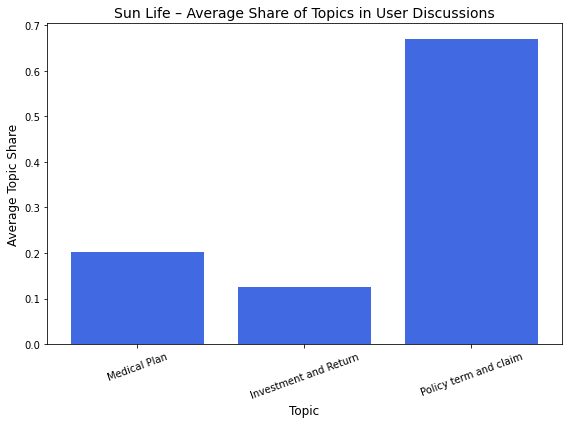

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件（请调整路径）
df = pd.read_csv("final_results/topics/Sun Life_doc_topic_matrix.csv")

# 自动选择数值型列作为主题列（假定元数据为非数值型）
topic_cols = df.select_dtypes(include=['number']).columns.tolist()
topic_means = df[topic_cols].mean()

# 绘图
plt.figure(figsize=(8, 6))
plt.bar(topic_means.index, topic_means.values, color='royalblue')
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Average Topic Share", fontsize=12)
plt.title("Sun Life – Average Share of Topics in User Discussions", fontsize=14)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


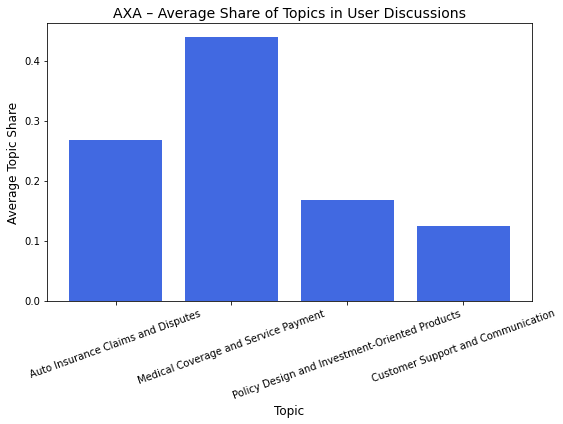

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件（请调整路径）
df = pd.read_csv("final_results/topics/AXA_doc_topic_matrix.csv")

# 自动选择数值型列作为主题列（假定元数据为非数值型）
topic_cols = df.select_dtypes(include=['number']).columns.tolist()
topic_means = df[topic_cols].mean()

# 绘图
plt.figure(figsize=(8, 6))
plt.bar(topic_means.index, topic_means.values, color='royalblue')
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Average Topic Share", fontsize=12)
plt.title("AXA – Average Share of Topics in User Discussions", fontsize=14)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


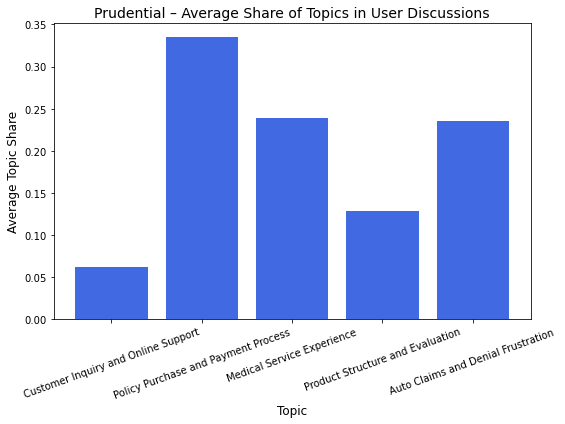

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件（请调整路径）
df = pd.read_csv("final_results/topics/Prudential_doc_topic_matrix.csv")

# 自动选择数值型列作为主题列（假定元数据为非数值型）
topic_cols = df.select_dtypes(include=['number']).columns.tolist()
topic_means = df[topic_cols].mean()

# 绘图
plt.figure(figsize=(8, 6))
plt.bar(topic_means.index, topic_means.values, color='royalblue')
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Average Topic Share", fontsize=12)
plt.title("Prudential – Average Share of Topics in User Discussions", fontsize=14)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


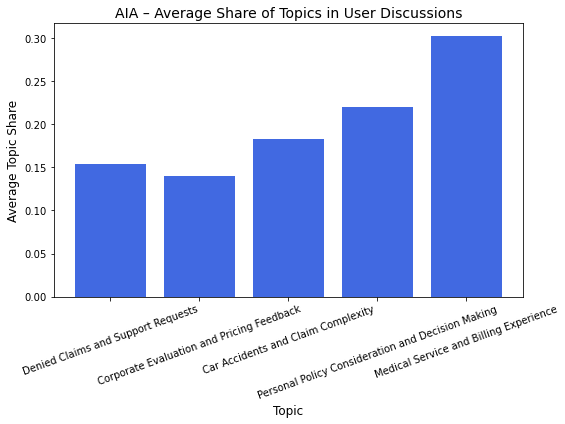

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件（请调整路径）
df = pd.read_csv("final_results/topics/AIA_doc_topic_matrix.csv")

# 自动选择数值型列作为主题列（假定元数据为非数值型）
topic_cols = df.select_dtypes(include=['number']).columns.tolist()
topic_means = df[topic_cols].mean()

# 绘图
plt.figure(figsize=(8, 6))
plt.bar(topic_means.index, topic_means.values, color='royalblue')
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Average Topic Share", fontsize=12)
plt.title("AIA – Average Share of Topics in User Discussions", fontsize=14)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


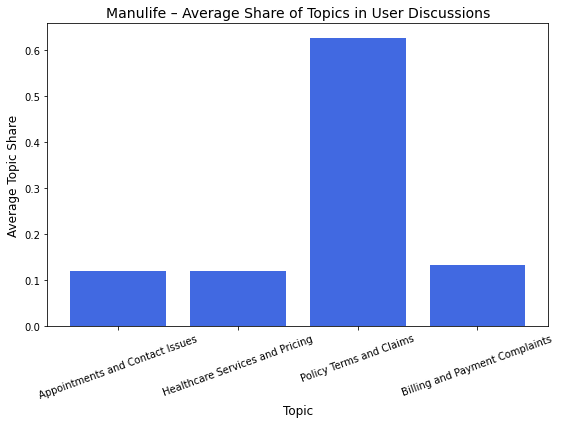

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取 CSV 文件（请调整路径）
df = pd.read_csv("final_results/topics/Manulife_doc_topic_matrix.csv")

# 自动选择数值型列作为主题列（假定元数据为非数值型）
topic_cols = df.select_dtypes(include=['number']).columns.tolist()
topic_means = df[topic_cols].mean()

# 绘图
plt.figure(figsize=(8, 6))
plt.bar(topic_means.index, topic_means.values, color='royalblue')
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Average Topic Share", fontsize=12)
plt.title("Manulife – Average Share of Topics in User Discussions", fontsize=14)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


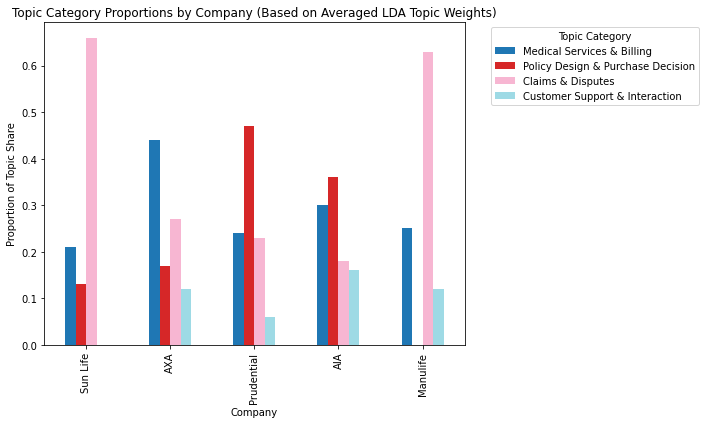

In [16]:


sunlife = {"Medical Plan": 0.21, "Investment and Return": 0.13, "Policy term and claim": 0.66}
axa = {
    "Auto Insurance Claims and Disputes": 0.27,
    "Medical Coverage and Service Payment": 0.44,
    "Policy Design and Investment-Oriented Products": 0.17,
    "Customer Support and Communication": 0.12
}
prudential = {
    "Customer Inquiry and Online Support": 0.06,
    "Policy Purchase and Payment Process": 0.34,
    "Medical Service Experience": 0.24,
    "Product Structure and Evaluation": 0.13,
    "Auto Claims and Denial Frustration": 0.23
}
aia = {
    "Denied Claims and Support Requests": 0.16,
    "Corporate Evaluation and Pricing Feedback": 0.14,
    "Car Accidents and Claim Complexity": 0.18,
    "Personal Policy Consideration and Decision Making": 0.22,
    "Medical Service and Billing Experience": 0.30
}
manulife = {
    "Appointments and Contact Issues": 0.12,
    "Healthcare Services and Pricing": 0.12,
    "Policy Terms and Claims": 0.63,
    "Billing and Payment Complaints": 0.13
}

# 话题映射至四大类
topic_mapping = {
    # Sun Life
    "Medical Plan": "Medical Services & Billing",
    "Investment and Return": "Policy Design & Purchase Decision",
    "Policy term and claim": "Claims & Disputes",
    # AXA
    "Auto Insurance Claims and Disputes": "Claims & Disputes",
    "Medical Coverage and Service Payment": "Medical Services & Billing",
    "Policy Design and Investment-Oriented Products": "Policy Design & Purchase Decision",
    "Customer Support and Communication": "Customer Support & Interaction",
    # Prudential
    "Customer Inquiry and Online Support": "Customer Support & Interaction",
    "Policy Purchase and Payment Process": "Policy Design & Purchase Decision",
    "Medical Service Experience": "Medical Services & Billing",
    "Product Structure and Evaluation": "Policy Design & Purchase Decision",
    "Auto Claims and Denial Frustration": "Claims & Disputes",
    # AIA
    "Denied Claims and Support Requests": "Customer Support & Interaction",
    "Corporate Evaluation and Pricing Feedback": "Policy Design & Purchase Decision",
    "Car Accidents and Claim Complexity": "Claims & Disputes",
    "Personal Policy Consideration and Decision Making": "Policy Design & Purchase Decision",
    "Medical Service and Billing Experience": "Medical Services & Billing",
    # Manulife
    "Appointments and Contact Issues": "Customer Support & Interaction",
    "Healthcare Services and Pricing": "Medical Services & Billing",
    "Policy Terms and Claims": "Claims & Disputes",
    "Billing and Payment Complaints": "Medical Services & Billing"
}

# 聚合到四大类
companies = {"Sun Life": sunlife, "AXA": axa, "Prudential": prudential, "AIA": aia, "Manulife": manulife}

category_summary = {}
for company, topic_dist in companies.items():
    summary = {}
    for topic, value in topic_dist.items():
        category = topic_mapping[topic]
        summary[category] = summary.get(category, 0) + value
    category_summary[company] = summary

# 转换为 DataFrame
df_category = pd.DataFrame(category_summary).T.fillna(0)

# 绘制比例对比图
df_category.plot(kind="bar", figsize=(10, 6), colormap="tab20")
plt.title("Topic Category Proportions by Company (Based on Averaged LDA Topic Weights)")
plt.xlabel("Company")
plt.ylabel("Proportion of Topic Share")
plt.legend(title="Topic Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# 时间序列分析

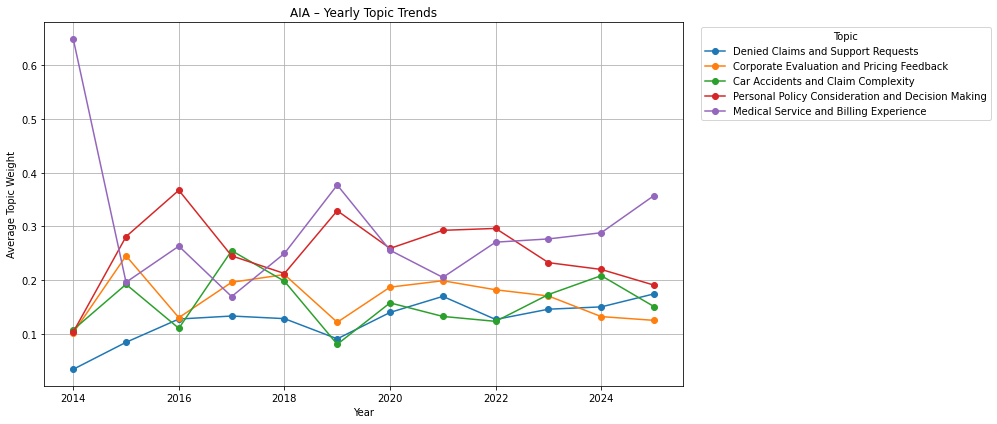

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
df_aia = pd.read_csv("final_results/topics/AIA_doc_topic_matrix.csv")

# 处理时间列
df_aia['created_utc'] = pd.to_datetime(df_aia['created_utc'], errors='coerce')
df_aia = df_aia.dropna(subset=['created_utc'])

# 添加年份字段
df_aia['year'] = df_aia['created_utc'].dt.year

# 获取所有主题列
topic_cols = df_aia.select_dtypes('float').columns.tolist()

# 按年聚合计算每个主题的均值
yearly_avg = df_aia.groupby('year')[topic_cols].mean()

# 转换索引为 list，避免 matplotlib 报错
x = yearly_avg.index.tolist()

# 绘图
plt.figure(figsize=(14, 6))
for topic in yearly_avg.columns:
    plt.plot(x, yearly_avg[topic].values, label=topic, marker='o')

plt.title("AIA – Yearly Topic Trends")
plt.xlabel("Year")
plt.ylabel("Average Topic Weight")
plt.grid(True)
plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


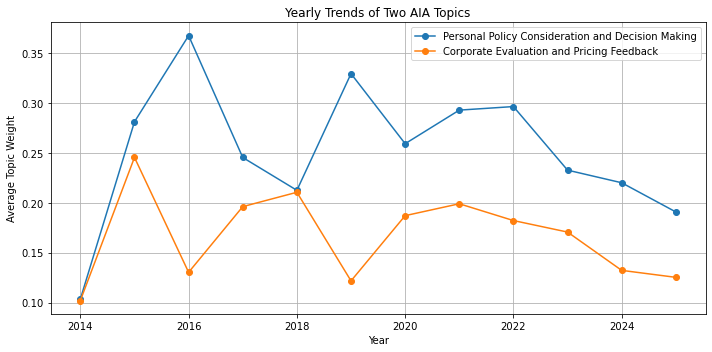

Pearson correlation: 0.240
p-value: 0.4524


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# === Step 1: 读取数据 ===
df = pd.read_csv("final_results/topics/AIA_doc_topic_matrix.csv")

# === Step 2: 处理时间列，按年聚合 ===
df["created_utc"] = pd.to_datetime(df["created_utc"], errors="coerce")
df = df.dropna(subset=["created_utc"])
df["year"] = df["created_utc"].dt.year

# === Step 3: 选定两个 topic 并按年聚合平均值 ===
topic1 = "Personal Policy Consideration and Decision Making"
topic2 = "Corporate Evaluation and Pricing Feedback"

yearly_avg = df.groupby("year")[[topic1, topic2]].mean()

# === Step 4: 转换索引为列表，防止绘图报错 ===
years = yearly_avg.index.tolist()

# === Step 5: 绘图趋势 ===
plt.figure(figsize=(10, 5))
plt.plot(years, yearly_avg[topic1].values, label=topic1, marker='o')
plt.plot(years, yearly_avg[topic2].values, label=topic2, marker='o')
plt.title("Yearly Trends of Two AIA Topics")
plt.xlabel("Year")
plt.ylabel("Average Topic Weight")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Step 6: 计算 Pearson 相关系数 ===
correlation, p_value = pearsonr(yearly_avg[topic1], yearly_avg[topic2])
print(f"Pearson correlation: {correlation:.3f}")
print(f"p-value: {p_value:.4f}")


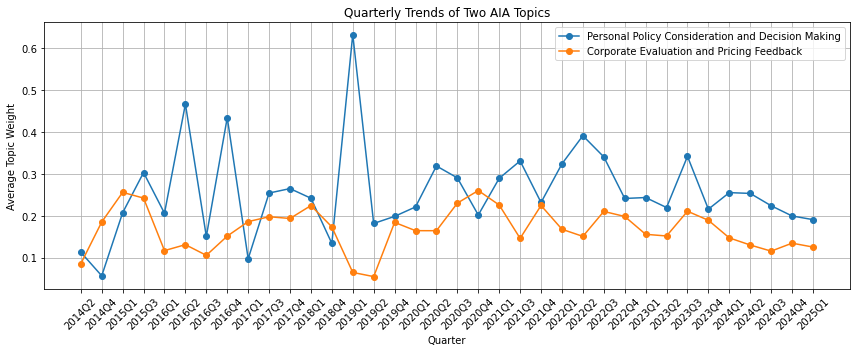

Pearson correlation (Quarterly): -0.118
p-value: 0.4918


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# === Step 1: 读取数据 ===
df = pd.read_csv("final_results/topics/AIA_doc_topic_matrix.csv")

# === Step 2: 处理时间列并提取季度 ===
df["created_utc"] = pd.to_datetime(df["created_utc"], errors="coerce")
df = df.dropna(subset=["created_utc"])
df["quarter"] = df["created_utc"].dt.to_period("Q")

# === Step 3: 选定两个话题并按季度聚合 ===
topic1 = "Personal Policy Consideration and Decision Making"
topic2 = "Corporate Evaluation and Pricing Feedback"

quarterly_avg = df.groupby("quarter")[[topic1, topic2]].mean()

# 转换 PeriodIndex 为字符串，防止绘图出错
quarters = quarterly_avg.index.astype(str).tolist()

# === Step 4: 可视化季度趋势 ===
plt.figure(figsize=(12, 5))
plt.plot(quarters, quarterly_avg[topic1].values, label=topic1, marker='o')
plt.plot(quarters, quarterly_avg[topic2].values, label=topic2, marker='o')
plt.title("Quarterly Trends of Two AIA Topics")
plt.xlabel("Quarter")
plt.ylabel("Average Topic Weight")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === Step 5: 计算 Pearson 相关性 ===
corr, pval = pearsonr(quarterly_avg[topic1], quarterly_avg[topic2])
print(f"Pearson correlation (Quarterly): {corr:.3f}")
print(f"p-value: {pval:.4f}")


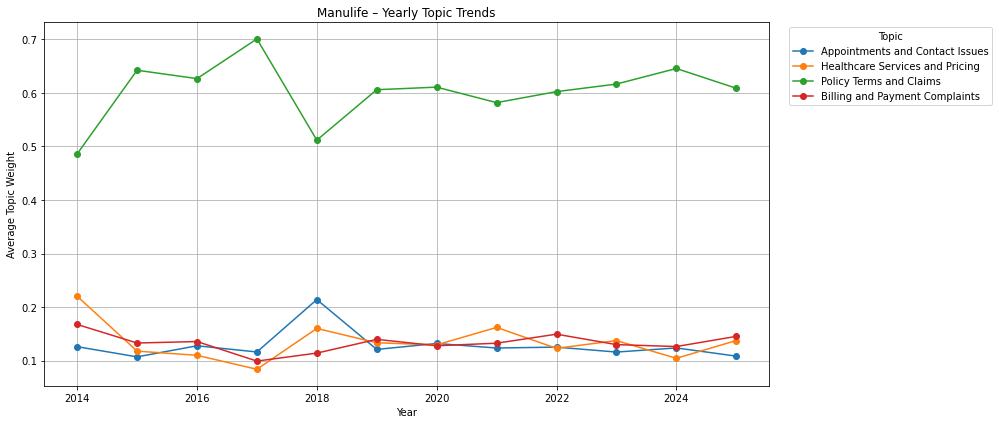

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
df_Manulife = pd.read_csv("final_results/topics/Manulife_doc_topic_matrix.csv")

# 处理时间列
df_Manulife['created_utc'] = pd.to_datetime(df_Manulife['created_utc'], errors='coerce')
df_Manulife = df_Manulife.dropna(subset=['created_utc'])

# 添加年份字段
df_Manulife['year'] = df_Manulife['created_utc'].dt.year

# 获取所有主题列
topic_cols = df_Manulife.select_dtypes('float').columns.tolist()

# 按年聚合计算每个主题的均值
yearly_avg = df_Manulife.groupby('year')[topic_cols].mean()

# 转换索引为 list，避免 matplotlib 报错
x = yearly_avg.index.tolist()

# 绘图
plt.figure(figsize=(14, 6))
for topic in yearly_avg.columns:
    plt.plot(x, yearly_avg[topic].values, label=topic, marker='o')

plt.title("Manulife – Yearly Topic Trends")
plt.xlabel("Year")
plt.ylabel("Average Topic Weight")
plt.grid(True)
plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


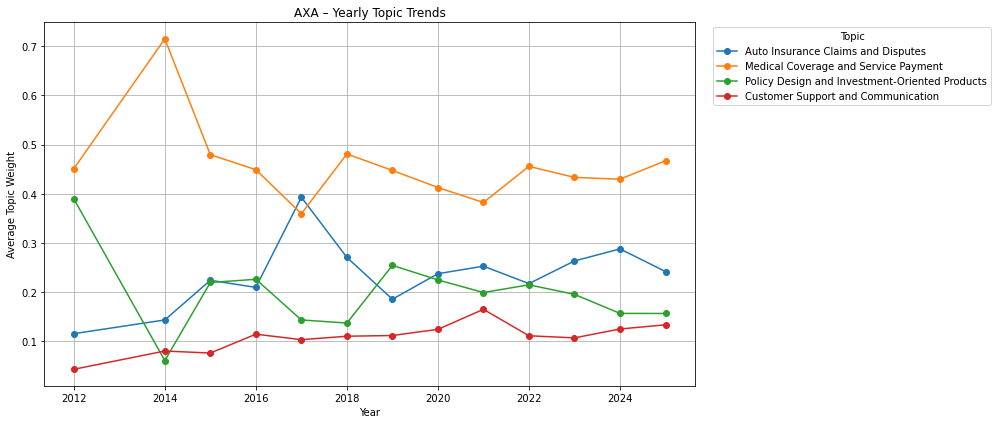

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
df_AXA = pd.read_csv("final_results/topics/AXA_doc_topic_matrix.csv")

# 处理时间列
df_AXA['created_utc'] = pd.to_datetime(df_AXA['created_utc'], errors='coerce')
df_AXA = df_AXA.dropna(subset=['created_utc'])

# 添加年份字段
df_AXA['year'] = df_AXA['created_utc'].dt.year

# 获取所有主题列
topic_cols = df_AXA.select_dtypes('float').columns.tolist()

# 按年聚合计算每个主题的均值
yearly_avg = df_AXA.groupby('year')[topic_cols].mean()

# 转换索引为 list，避免 matplotlib 报错
x = yearly_avg.index.tolist()

# 绘图
plt.figure(figsize=(14, 6))
for topic in yearly_avg.columns:
    plt.plot(x, yearly_avg[topic].values, label=topic, marker='o')

plt.title("AXA – Yearly Topic Trends")
plt.xlabel("Year")
plt.ylabel("Average Topic Weight")
plt.grid(True)
plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


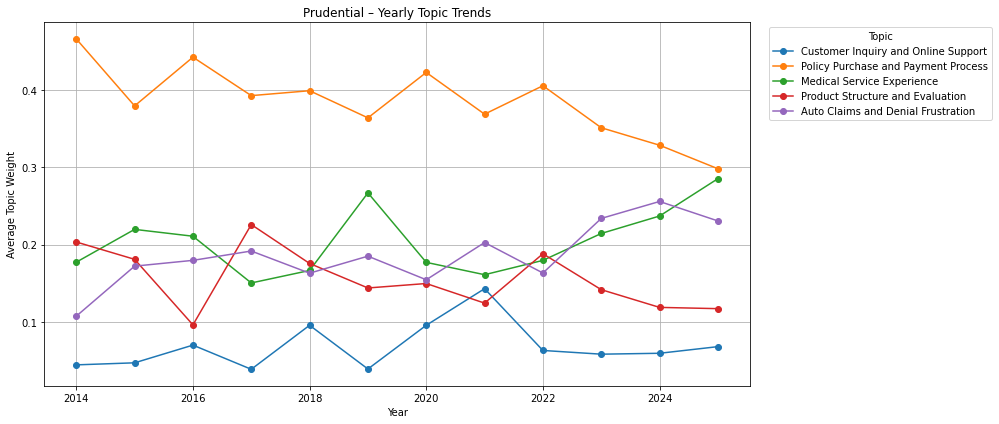

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
df_Prudential = pd.read_csv("final_results/topics/Prudential_doc_topic_matrix.csv")

# 处理时间列
df_Prudential['created_utc'] = pd.to_datetime(df_Prudential['created_utc'], errors='coerce')
df_Prudential = df_Prudential.dropna(subset=['created_utc'])

# 添加年份字段
df_Prudential['year'] = df_Prudential['created_utc'].dt.year

# 获取所有主题列
topic_cols = df_Prudential.select_dtypes('float').columns.tolist()

# 按年聚合计算每个主题的均值
yearly_avg = df_Prudential.groupby('year')[topic_cols].mean()

# 转换索引为 list，避免 matplotlib 报错
x = yearly_avg.index.tolist()

# 绘图
plt.figure(figsize=(14, 6))
for topic in yearly_avg.columns:
    plt.plot(x, yearly_avg[topic].values, label=topic, marker='o')

plt.title("Prudential – Yearly Topic Trends")
plt.xlabel("Year")
plt.ylabel("Average Topic Weight")
plt.grid(True)
plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


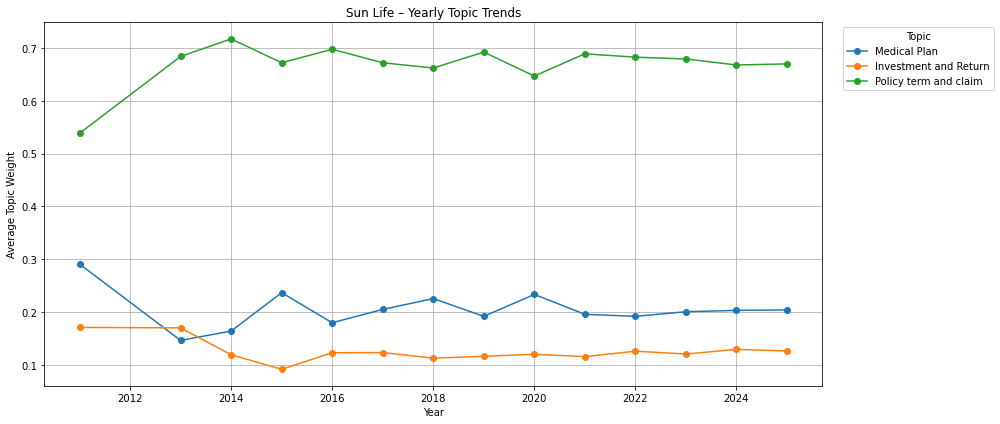

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
df_Sun_Life = pd.read_csv("final_results/topics/Sun Life_doc_topic_matrix.csv")

# 处理时间列
df_Sun_Life['created_utc'] = pd.to_datetime(df_Sun_Life['created_utc'], errors='coerce')
df_Sun_Life = df_Sun_Life.dropna(subset=['created_utc'])

# 添加年份字段
df_Sun_Life['year'] = df_Sun_Life['created_utc'].dt.year

# 获取所有主题列
topic_cols = df_Sun_Life.select_dtypes('float').columns.tolist()

# 按年聚合计算每个主题的均值
yearly_avg = df_Sun_Life.groupby('year')[topic_cols].mean()

# 转换索引为 list，避免 matplotlib 报错
x = yearly_avg.index.tolist()

# 绘图
plt.figure(figsize=(14, 6))
for topic in yearly_avg.columns:
    plt.plot(x, yearly_avg[topic].values, label=topic, marker='o')

plt.title("Sun Life – Yearly Topic Trends")
plt.xlabel("Year")
plt.ylabel("Average Topic Weight")
plt.grid(True)
plt.legend(title="Topic", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


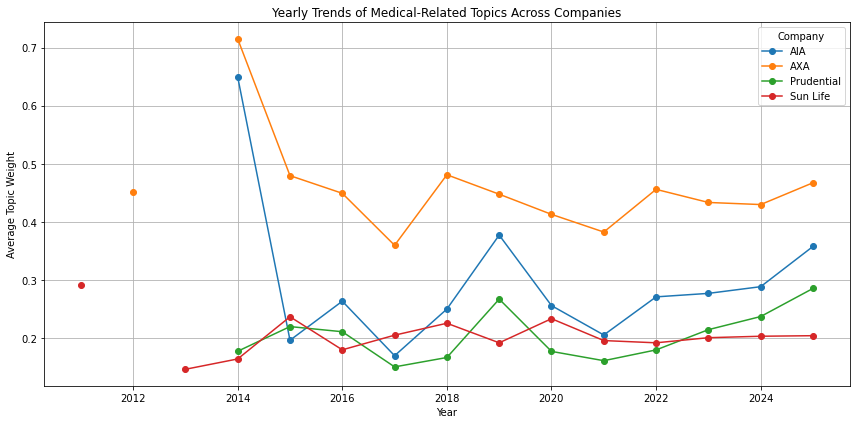

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 公司列表
companies = ["AIA", "AXA", "Prudential", "Manulife", "Sun Life"]
base_path = "final_results/topics/"

# 存储所有公司年度均值
plot_data = {}

for company in companies:
    file_path = os.path.join(base_path, f"{company}_doc_topic_matrix.csv")
    try:
        df = pd.read_csv(file_path)
        df['created_utc'] = pd.to_datetime(df['created_utc'], errors='coerce')
        df = df.dropna(subset=['created_utc'])
        df['year'] = df['created_utc'].dt.year

        # 提取“medical”相关的列
        topic_cols = df.select_dtypes(include='float').columns
        medical_cols = [col for col in topic_cols if 'medical' in col.lower()]
        if not medical_cols:
            continue

        # 取多个medical话题的平均值
        df['medical_avg'] = df[medical_cols].mean(axis=1)

        # 按年份聚合
        yearly = df.groupby('year')['medical_avg'].mean()
        plot_data[company] = yearly

    except Exception as e:
        print(f"[ERROR] {company} failed: {e}")

# 整合所有公司数据
combined_df = pd.DataFrame(plot_data)

# 将 index 强制转为 list 确保可绘图
x = combined_df.index.tolist()

# 绘图
plt.figure(figsize=(12, 6))
for company in combined_df.columns:
    plt.plot(x, combined_df[company].values, marker='o', label=company)

plt.title("Yearly Trends of Medical-Related Topics Across Companies")
plt.xlabel("Year")
plt.ylabel("Average Topic Weight")
plt.grid(True)
plt.legend(title="Company")
plt.tight_layout()
plt.show()


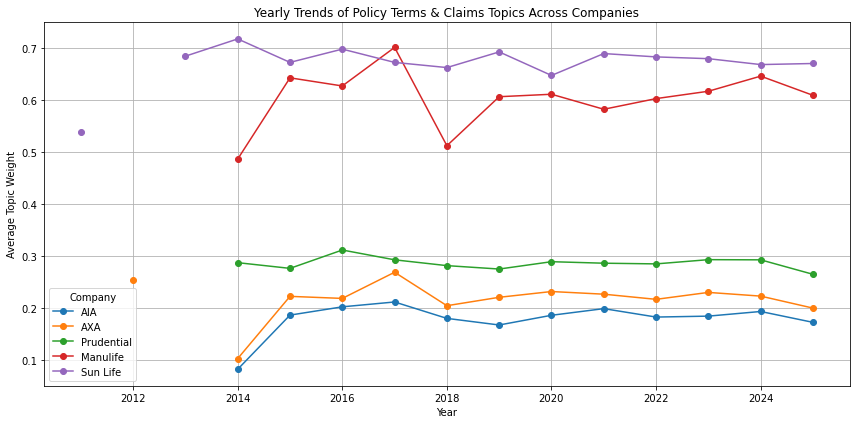

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 公司列表
companies = ["AIA", "AXA", "Prudential", "Manulife", "Sun Life"]
base_path = "final_results/topics/"

# 存储数据
plot_data = {}

for company in companies:
    file_path = os.path.join(base_path, f"{company}_doc_topic_matrix.csv")
    try:
        df = pd.read_csv(file_path)
        df['created_utc'] = pd.to_datetime(df['created_utc'], errors='coerce')
        df.dropna(subset=['created_utc'], inplace=True)
        df['year'] = df['created_utc'].dt.year

        # 自动识别与 policy / claim 相关的 topic
        topic_cols = df.select_dtypes(include='float').columns
        target_cols = [col for col in topic_cols if 'policy' in col.lower() or 'claim' in col.lower()]
        if not target_cols:
            continue

        # 平均值
        df['policy_claim_avg'] = df[target_cols].mean(axis=1)
        yearly_avg = df.groupby('year')['policy_claim_avg'].mean()
        plot_data[company] = yearly_avg

    except Exception as e:
        print(f"[ERROR] {company} failed: {e}")

# 合并数据
combined_df = pd.DataFrame(plot_data)

# 画图
plt.figure(figsize=(12, 6))
for company in combined_df.columns:
    plt.plot(combined_df.index.tolist(), combined_df[company].values, marker='o', label=company)

plt.title("Yearly Trends of Policy Terms & Claims Topics Across Companies")
plt.xlabel("Year")
plt.ylabel("Average Topic Weight")
plt.grid(True)
plt.legend(title="Company")
plt.tight_layout()
plt.show()


# 查看评论和帖子的差异

<Figure size 720x360 with 0 Axes>

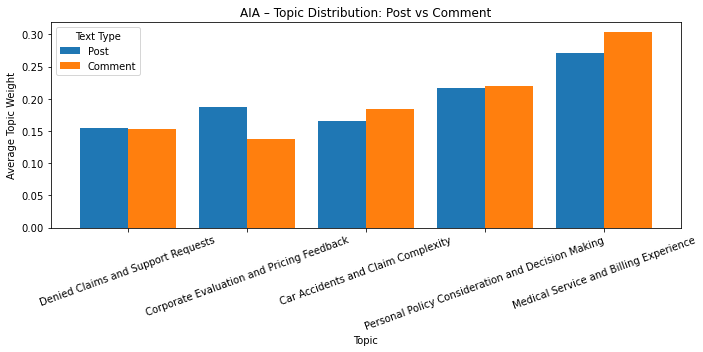

<Figure size 720x360 with 0 Axes>

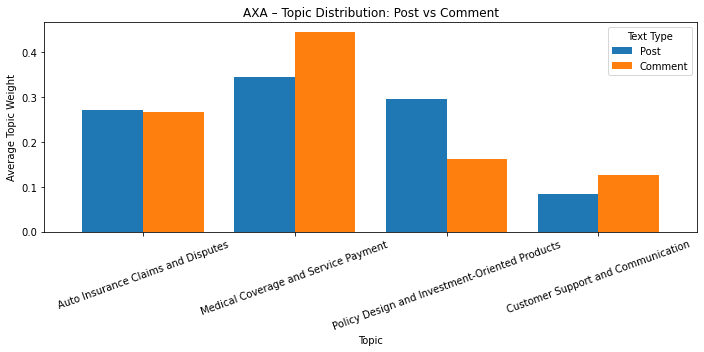

<Figure size 720x360 with 0 Axes>

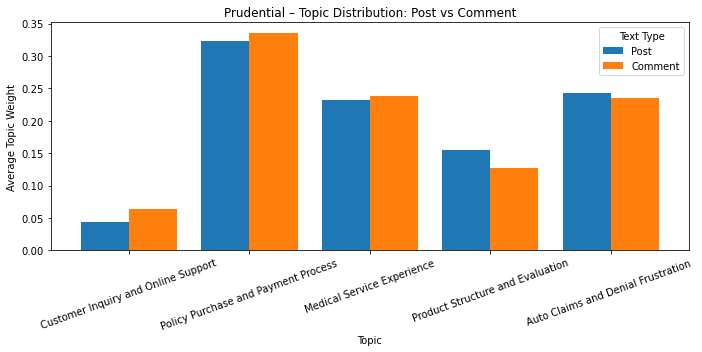

<Figure size 720x360 with 0 Axes>

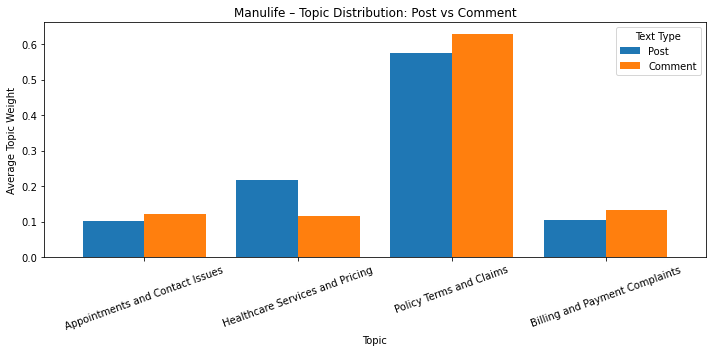

<Figure size 720x360 with 0 Axes>

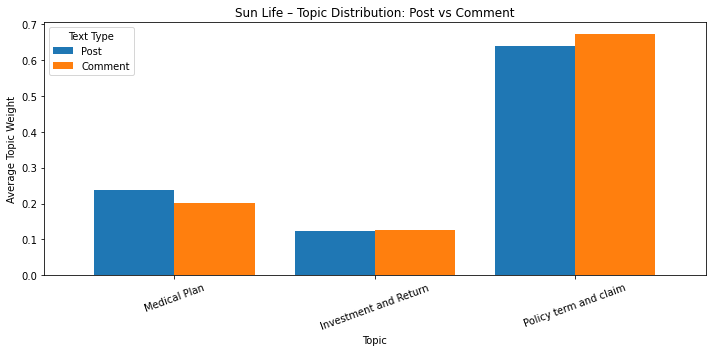

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# 公司列表
companies = ["AIA", "AXA", "Prudential", "Manulife", "Sun Life"]
base_path = "final_results/topics/"

for company in companies:
    file_path = os.path.join(base_path, f"{company}_doc_topic_matrix.csv")

    try:
        df = pd.read_csv(file_path)
        
        topic_cols = df.select_dtypes(include='float').columns.tolist()

        # 分组并确保顺序
        grouped = df.groupby("type")[topic_cols].mean().T
        grouped = grouped[["post", "comment"]]  # 注意顺序
        grouped.columns = ["Post", "Comment"]   # 设置展示标题

        # 设置索引
        grouped["Topic"] = grouped.index
        grouped.set_index("Topic", inplace=True)

        # 绘图
        plt.figure(figsize=(10, 5))
        grouped[["Post", "Comment"]].plot(kind="bar", width=0.8, figsize=(10, 5),
                                          title=f"{company} – Topic Distribution: Post vs Comment")
        plt.xlabel("Topic")
        plt.ylabel("Average Topic Weight")
        plt.xticks(rotation=20)
        plt.legend(title="Text Type")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"[ERROR] Failed to process {company}: {e}")


# t检验

In [6]:
import pandas as pd
import scipy.stats as stats
import os

# 公司列表
companies = ["AIA", "AXA", "Prudential", "Manulife", "Sun Life"]
base_path = "final_results/topics/"

results = []

for company in companies:
    file_path = os.path.join(base_path, f"{company}_doc_topic_matrix.csv")

    try:
        df = pd.read_csv(file_path)

        # 选出所有 topic 列（float 类型）
        topic_cols = df.select_dtypes(include='float').columns.tolist()

        for topic in topic_cols:
            post_values = df[df["type"] == "post"][topic]
            comment_values = df[df["type"] == "comment"][topic]

            # t 检验
            t_stat, p_value = stats.ttest_ind(post_values, comment_values, equal_var=False, nan_policy='omit')

            results.append({
                "Company": company,
                "Topic": topic,
                "Post Mean": post_values.mean(),
                "Comment Mean": comment_values.mean(),
                "t-stat": t_stat,
                "p-value": p_value,
                "Significant": p_value < 0.01
            })

    except Exception as e:
        print(f"[ERROR] {company} failed: {e}")

# 汇总成 DataFrame
df_results = pd.DataFrame(results)

# 输出所有结果
print("\n=== All Topic Results Across Companies ===")
print(df_results)

# 输出显著差异的部分
significant = df_results[df_results["Significant"] == True]
print("\n=== Topics with Significant Differences Between Posts and Comments ===")
print(significant)

# 也可以保存
df_results.to_csv("all_company_topic_ttest_results.csv", index=False)
significant.to_csv("significant_topic_differences.csv", index=False)



=== All Topic Results Across Companies ===
       Company                                              Topic  Post Mean  \
0          AIA                 Denied Claims and Support Requests   0.155165   
1          AIA          Corporate Evaluation and Pricing Feedback   0.186874   
2          AIA                 Car Accidents and Claim Complexity   0.165935   
3          AIA  Personal Policy Consideration and Decision Making   0.216515   
4          AIA             Medical Service and Billing Experience   0.270785   
5          AXA                 Auto Insurance Claims and Disputes   0.272424   
6          AXA               Medical Coverage and Service Payment   0.345263   
7          AXA     Policy Design and Investment-Oriented Products   0.295865   
8          AXA                 Customer Support and Communication   0.085120   
9   Prudential                Customer Inquiry and Online Support   0.043443   
10  Prudential                Policy Purchase and Payment Process   0.323060

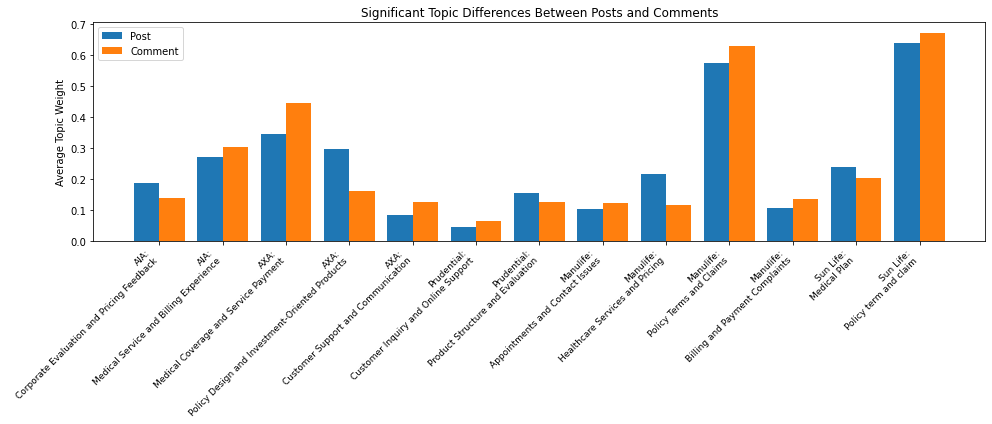

In [8]:
# 再次尝试绘图
import pandas as pd
import matplotlib.pyplot as plt

# 构建显著性差异数据
data = {
    "Company": [
        "AIA", "AIA", "AXA", "AXA", "AXA", "Prudential", "Prudential",
        "Manulife", "Manulife", "Manulife", "Manulife", "Sun Life", "Sun Life"
    ],
    "Topic": [
        "Corporate Evaluation and Pricing Feedback",
        "Medical Service and Billing Experience",
        "Medical Coverage and Service Payment",
        "Policy Design and Investment-Oriented Products",
        "Customer Support and Communication",
        "Customer Inquiry and Online Support",
        "Product Structure and Evaluation",
        "Appointments and Contact Issues",
        "Healthcare Services and Pricing",
        "Policy Terms and Claims",
        "Billing and Payment Complaints",
        "Medical Plan",
        "Policy term and claim"
    ],
    "Post Mean": [
        0.186874, 0.270785, 0.345263, 0.295865, 0.085120,
        0.043443, 0.154257, 0.101554, 0.217330, 0.574945, 0.105718,
        0.237806, 0.639550
    ],
    "Comment Mean": [
        0.137999, 0.303451, 0.444774, 0.161492, 0.125629,
        0.063569, 0.126893, 0.120931, 0.115493, 0.629940, 0.133614,
        0.201732, 0.671759
    ]
}

df = pd.DataFrame(data)

# 设置绘图样式
plt.figure(figsize=(14, 6))
x = range(len(df))
bar_width = 0.4

# 柱状图
plt.bar([i - bar_width/2 for i in x], df["Post Mean"], width=bar_width, label="Post")
plt.bar([i + bar_width/2 for i in x], df["Comment Mean"], width=bar_width, label="Comment")

# 美化
plt.xticks(ticks=x, labels=[f"{row['Company']}:\n{row['Topic']}" for _, row in df.iterrows()],
           rotation=45, ha="right", fontsize=9)
plt.ylabel("Average Topic Weight")
plt.title("Significant Topic Differences Between Posts and Comments")
plt.legend()
plt.tight_layout()

plt.show()


# LSTM预测

Epoch 1/300


D:\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.1180 - val_loss: 0.0143
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0472 - val_loss: 0.0105
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0472 - val_loss: 0.0301
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0312 - val_loss: 0.0170
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0453 - val_loss: 0.0118
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0302 - val_loss: 0.0169
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0330 - val_loss: 0.0174
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0348 - val_loss: 0.0167
Epoch 9/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0399 - val_loss: 0.0152
Epoch 10/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0356 - val_loss: 0.0224
Epoch 11/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0361 - val_loss: 0.0168
Epoch 12/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0259 - val_loss: 0.0157


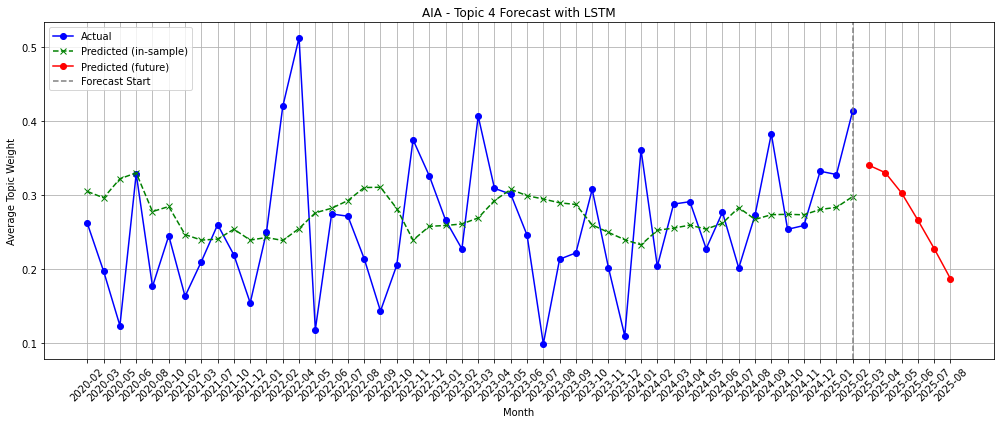

Train RMSE: 0.1220, MAE: 0.0929
Test  RMSE: 0.0661, MAE: 0.0516


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# === 读取 & 预处理数据 ===
df = pd.read_csv("final_results/topics/AIA_doc_topic_matrix.csv")
df['created_utc'] = pd.to_datetime(df['created_utc'], errors='coerce')
df.dropna(subset=['created_utc'], inplace=True)
df['month'] = df['created_utc'].dt.to_period('M')
monthly = df.groupby('month')['topic_4'].mean().reset_index()
monthly['month'] = monthly['month'].astype(str)

# === 归一化处理 ===
scaler = MinMaxScaler()
scaled = scaler.fit_transform(monthly[['topic_4']].values)

# === 构建 LSTM 输入序列 ===
window = 6
X, y = [], []
for i in range(len(scaled) - window):
    X.append(scaled[i:i+window])
    y.append(scaled[i+window])
X, y = np.array(X), np.array(y)

# === 划分训练 & 测试集 ===
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(window, 1)))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# 添加提前停止机制：提升稳定性 + 避免过拟合
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=300, 
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# 预测 + 反归一化
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_train_pred_inv = scaler.inverse_transform(y_train_pred)
y_test_pred_inv = scaler.inverse_transform(y_test_pred)
y_train_inv = scaler.inverse_transform(y_train)
y_test_inv = scaler.inverse_transform(y_test)
predicted_full = np.vstack((y_train_pred_inv, y_test_pred_inv)).flatten()

# 截取从2020年开始的部分（用于画图）
start_date = '2020-01'
mask = monthly['month'] >= start_date
x_actual = monthly['month'][mask].astype(str).to_numpy()
y_actual = monthly['topic_4'][mask].to_numpy()

# 预测值对应的横坐标
x_pred = monthly['month'][window:].astype(str).to_numpy()
y_pred = predicted_full

# 同样裁剪预测值，只保留2020年以后的
pred_mask = x_pred >= start_date
x_pred = x_pred[pred_mask]
y_pred = y_pred[pred_mask]

# 未来趋势（不变）
x_future = np.array([str(d) for d in future_dates])
y_future = np.array(future_preds_inv)

# === 可视化部分 ===
plt.figure(figsize=(14, 6))
plt.plot(x_actual, y_actual, label='Actual', marker='o', color='blue')
plt.plot(x_pred, y_pred, label='Predicted (in-sample)', linestyle='--', marker='x', color='green')
plt.plot(x_future, y_future, label='Predicted (future)', marker='o', color='red')
plt.axvline(x=x_actual[-1], color='gray', linestyle='--', label='Forecast Start')

plt.title("AIA - Topic 4 Forecast with LSTM")
plt.xlabel("Month")
plt.ylabel("Average Topic Weight")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 误差输出
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv)):.4f}, MAE: {mean_absolute_error(y_train_inv, y_train_pred_inv):.4f}")
print(f"Test  RMSE: {np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv)):.4f}, MAE: {mean_absolute_error(y_test_inv, y_test_pred_inv):.4f}")


Epoch 1/300


D:\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.1234 - val_loss: 0.0086
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0455 - val_loss: 0.0163
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0479 - val_loss: 0.0365
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0374 - val_loss: 0.0151
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0404 - val_loss: 0.0181
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0347 - val_loss: 0.0286
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0281 - val_loss: 0.0251
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0293 - val_loss: 0.0209
Epoch 9/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0399 - val_loss: 0.0178
Epoch 10/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0256 - val_loss: 0.0298
Epoch 11/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0326 - val_loss: 0.0227
Epoch 12/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0362 - val_loss: 0.0182
E

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_38412\4259247358.py:98: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(monthly['month'].iloc[-1] + '-01', periods=future_steps + 1, freq='M')[1:].strftime('%Y-%m').tolist()


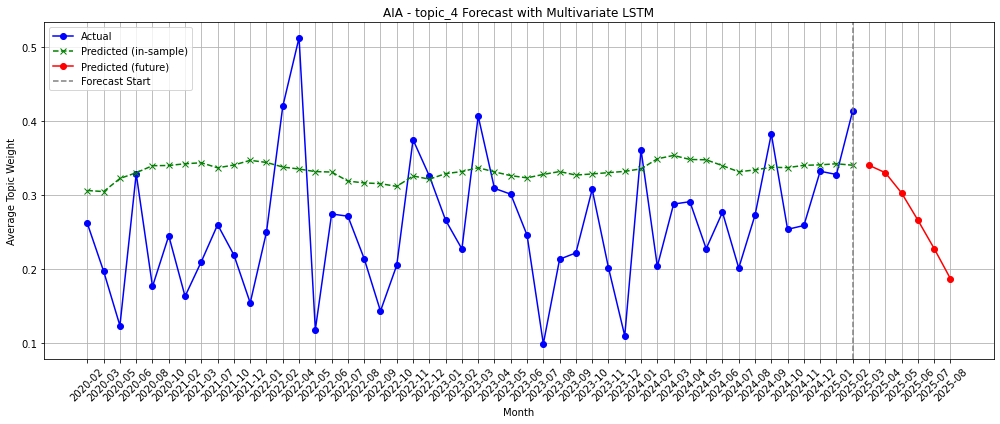

Train RMSE: 0.1409, MAE: 0.1184
Test  RMSE: 0.0598, MAE: 0.0525


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# === 读取 & 预处理数据 ===
df = pd.read_csv("final_results/topics/AIA_doc_topic_matrix.csv")
df['created_utc'] = pd.to_datetime(df['created_utc'], errors='coerce')
df.dropna(subset=['created_utc'], inplace=True)
df['month'] = df['created_utc'].dt.to_period('M')

# === 获取所有 topic 列并聚合 ===
topic_cols = [col for col in df.columns if col.startswith("topic_")]
monthly = df.groupby('month')[topic_cols].mean().reset_index()
monthly['month'] = monthly['month'].astype(str)

# === 归一化所有 topic ===
scaler = MinMaxScaler()
scaled = scaler.fit_transform(monthly[topic_cols])

# === 构建 LSTM 输入序列（多变量输入）===
window = 6
target_col = "topic_4"
target_idx = topic_cols.index(target_col)

X, y = [], []
for i in range(len(scaled) - window):
    X.append(scaled[i:i+window])
    y.append(scaled[i+window][target_idx])  # 只预测 topic_4

X, y = np.array(X), np.array(y)

# === 划分训练 & 测试集 ===
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === 构建 LSTM 模型 ===
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(window, X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# 添加提前停止机制
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# === 训练模型 ===
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# === 预测 + 反归一化 ===
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 构造用于反归一化的空矩阵
def inverse_single_output(pred, topic_index):
    dummy = np.zeros((pred.shape[0], len(topic_cols)))
    dummy[:, topic_index] = pred.flatten()
    return scaler.inverse_transform(dummy)[:, topic_index]

y_train_pred_inv = inverse_single_output(y_train_pred, target_idx)
y_test_pred_inv = inverse_single_output(y_test_pred, target_idx)
y_train_inv = inverse_single_output(y_train, target_idx)
y_test_inv = inverse_single_output(y_test, target_idx)

# === 构建完整预测序列（含 in-sample） ===
predicted_full = np.concatenate([y_train_pred_inv, y_test_pred_inv])
predicted_index = monthly['month'][window:].astype(str).values

# === 未来预测 ===
last_input = scaled[-window:]
future_steps = 6
future_preds = []

for _ in range(future_steps):
    pred = model.predict(last_input.reshape(1, window, len(topic_cols)), verbose=0)
    future_preds.append(pred[0, 0])
    
    # 构造新的输入（补上预测）
    new_input = np.zeros((1, len(topic_cols)))
    new_input[0, target_idx] = pred[0, 0]
    last_input = np.concatenate([last_input[1:], new_input], axis=0)

future_preds_inv = inverse_single_output(np.array(future_preds).reshape(-1, 1), target_idx)
future_dates = pd.date_range(monthly['month'].iloc[-1] + '-01', periods=future_steps + 1, freq='M')[1:].strftime('%Y-%m').tolist()

# === 可视化部分（2020 年以后） ===
start_date = '2020-01'
mask = monthly['month'] >= start_date
x_actual = monthly['month'][mask].to_numpy()
y_actual = monthly[target_col][mask].to_numpy()

x_pred = monthly['month'][window:].to_numpy()
y_pred = predicted_full

# 裁剪预测值显示
pred_mask = x_pred >= start_date
x_pred = x_pred[pred_mask]
y_pred = y_pred[pred_mask]

# 未来数据
x_future = np.array([str(d) for d in future_dates])
y_future = np.array(future_preds_inv)

# === 绘图 ===
plt.figure(figsize=(14, 6))
plt.plot(x_actual, y_actual, label='Actual', marker='o', color='blue')
plt.plot(x_pred, y_pred, label='Predicted (in-sample)', linestyle='--', marker='x', color='green')
plt.plot(x_future, y_future, label='Predicted (future)', marker='o', color='red')
plt.axvline(x=x_actual[-1], color='gray', linestyle='--', label='Forecast Start')

plt.title(f"AIA - {target_col} Forecast with Multivariate LSTM")
plt.xlabel("Month")
plt.ylabel("Average Topic Weight")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 输出误差 ===
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv)):.4f}, MAE: {mean_absolute_error(y_train_inv, y_train_pred_inv):.4f}")
print(f"Test  RMSE: {np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv)):.4f}, MAE: {mean_absolute_error(y_test_inv, y_test_pred_inv):.4f}")


Manulife

Epoch 1/300


D:\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - loss: 0.3020 - val_loss: 0.0081
Epoch 2/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0562 - val_loss: 0.0076
Epoch 3/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0334 - val_loss: 0.0258
Epoch 4/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0396 - val_loss: 0.0076
Epoch 5/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0466 - val_loss: 0.0095
Epoch 6/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0389 - val_loss: 0.0184
Epoch 7/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0236 - val_loss: 0.0087
Epoch 8/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0276 - val_loss: 0.0088
Epoch 9/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0438 - val_loss: 0.0109
Epoch 10/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0430 - val_loss: 0.0078
Epoch 11/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0400 - val_loss: 0.0140
Epoch 12/300
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0340 - val_loss: 0.0091
E

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_38412\2306214201.py:98: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(monthly['month'].iloc[-1] + '-01', periods=future_steps + 1, freq='M')[1:].strftime('%Y-%m').tolist()


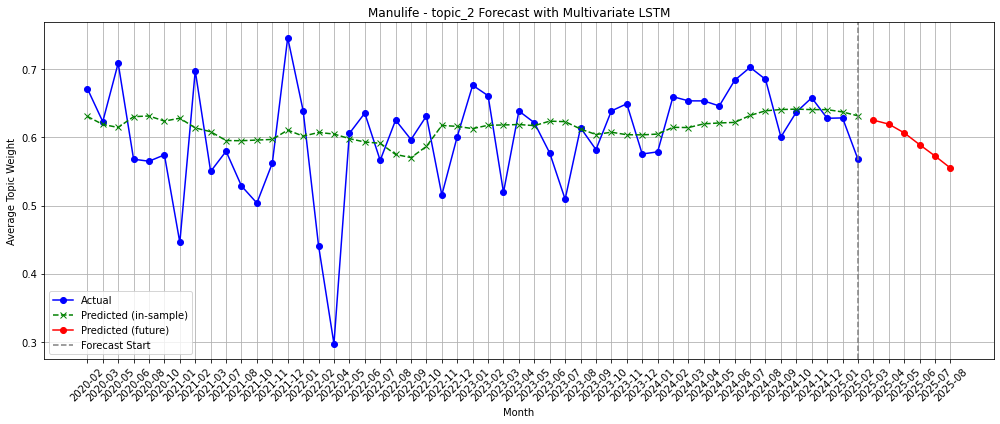

Train RMSE: 0.0894, MAE: 0.0694
Test  RMSE: 0.0409, MAE: 0.0330


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# === 读取 & 预处理数据 ===
df = pd.read_csv("final_results/topics/Manulife_doc_topic_matrix.csv")
df['created_utc'] = pd.to_datetime(df['created_utc'], errors='coerce')
df.dropna(subset=['created_utc'], inplace=True)
df['month'] = df['created_utc'].dt.to_period('M')

# === 获取所有 topic 列并聚合 ===
topic_cols = [col for col in df.columns if col.startswith("topic_")]
monthly = df.groupby('month')[topic_cols].mean().reset_index()
monthly['month'] = monthly['month'].astype(str)

# === 归一化所有 topic ===
scaler = MinMaxScaler()
scaled = scaler.fit_transform(monthly[topic_cols])

# === 构建 LSTM 输入序列（多变量输入）===
window = 6
target_col = "topic_2"
target_idx = topic_cols.index(target_col)

X, y = [], []
for i in range(len(scaled) - window):
    X.append(scaled[i:i+window])
    y.append(scaled[i+window][target_idx])  # 只预测 topic_4

X, y = np.array(X), np.array(y)

# === 划分训练 & 测试集 ===
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === 构建 LSTM 模型 ===
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(window, X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# 添加提前停止机制
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# === 训练模型 ===
history = model.fit(
    X_train, y_train,
    epochs=300,
    batch_size=8,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# === 预测 + 反归一化 ===
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# 构造用于反归一化的空矩阵
def inverse_single_output(pred, topic_index):
    dummy = np.zeros((pred.shape[0], len(topic_cols)))
    dummy[:, topic_index] = pred.flatten()
    return scaler.inverse_transform(dummy)[:, topic_index]

y_train_pred_inv = inverse_single_output(y_train_pred, target_idx)
y_test_pred_inv = inverse_single_output(y_test_pred, target_idx)
y_train_inv = inverse_single_output(y_train, target_idx)
y_test_inv = inverse_single_output(y_test, target_idx)

# === 构建完整预测序列（含 in-sample） ===
predicted_full = np.concatenate([y_train_pred_inv, y_test_pred_inv])
predicted_index = monthly['month'][window:].astype(str).values

# === 未来预测 ===
last_input = scaled[-window:]
future_steps = 6
future_preds = []

for _ in range(future_steps):
    pred = model.predict(last_input.reshape(1, window, len(topic_cols)), verbose=0)
    future_preds.append(pred[0, 0])
    
    # 构造新的输入（补上预测）
    new_input = np.zeros((1, len(topic_cols)))
    new_input[0, target_idx] = pred[0, 0]
    last_input = np.concatenate([last_input[1:], new_input], axis=0)

future_preds_inv = inverse_single_output(np.array(future_preds).reshape(-1, 1), target_idx)
future_dates = pd.date_range(monthly['month'].iloc[-1] + '-01', periods=future_steps + 1, freq='M')[1:].strftime('%Y-%m').tolist()

# === 可视化部分（2020 年以后） ===
start_date = '2020-01'
mask = monthly['month'] >= start_date
x_actual = monthly['month'][mask].to_numpy()
y_actual = monthly[target_col][mask].to_numpy()

x_pred = monthly['month'][window:].to_numpy()
y_pred = predicted_full

# 裁剪预测值显示
pred_mask = x_pred >= start_date
x_pred = x_pred[pred_mask]
y_pred = y_pred[pred_mask]

# 未来数据
x_future = np.array([str(d) for d in future_dates])
y_future = np.array(future_preds_inv)

# === 绘图 ===
plt.figure(figsize=(14, 6))
plt.plot(x_actual, y_actual, label='Actual', marker='o', color='blue')
plt.plot(x_pred, y_pred, label='Predicted (in-sample)', linestyle='--', marker='x', color='green')
plt.plot(x_future, y_future, label='Predicted (future)', marker='o', color='red')
plt.axvline(x=x_actual[-1], color='gray', linestyle='--', label='Forecast Start')

plt.title(f"Manulife - {target_col} Forecast with Multivariate LSTM")
plt.xlabel("Month")
plt.ylabel("Average Topic Weight")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 输出误差 ===
print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv)):.4f}, MAE: {mean_absolute_error(y_train_inv, y_train_pred_inv):.4f}")
print(f"Test  RMSE: {np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv)):.4f}, MAE: {mean_absolute_error(y_test_inv, y_test_pred_inv):.4f}")


# 全行业预测

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3144\3323595764.py:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_features = monthly_features.sort_values("month").fillna(method="ffill").fillna(method="bfill")
D:\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.1324 - val_loss: 0.0170
Epoch 2/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0891 - val_loss: 0.0143
Epoch 3/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0734 - val_loss: 0.0115
Epoch 4/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0681 - val_loss: 0.0125
Epoch 5/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0605 - val_loss: 0.0207
Epoch 6/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0549 - val_loss: 0.0194
Epoch 7/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0493 - val_loss: 0.0235
Epoch 8/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0534 - val_loss: 0.0353
Epoch 9/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0510 - val_loss: 0.0302
Epoch 10/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0455 - val_loss: 0.0197
Epoch 11/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0534 - val_loss: 0.0241
Epoch 12/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss:

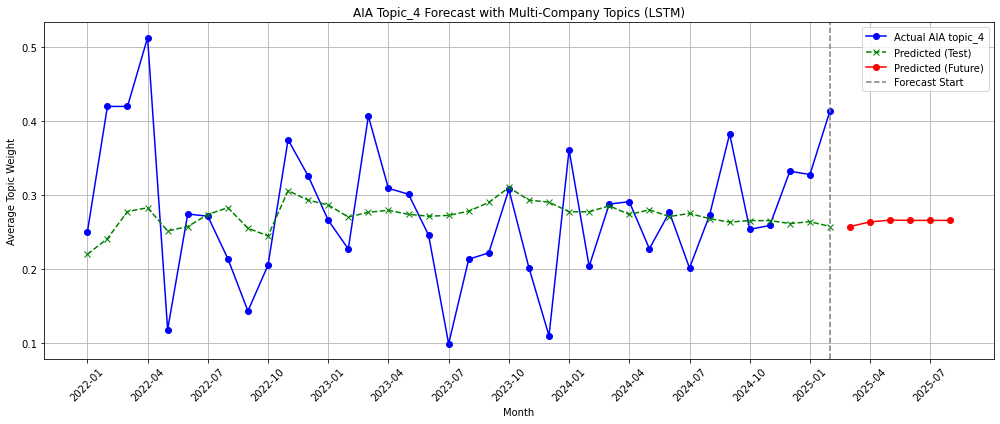

Test RMSE: 0.0690, MAE: 0.0506


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# === 公司列表 & 读取数据 ===
companies = ['AIA', 'AXA', 'Manulife', 'Sun Life', 'Prudential']
company_files = [f"final_results/topics/{c}_doc_topic_matrix.csv" for c in companies]

monthly_features = None
for file, company in zip(company_files, companies):
    df = pd.read_csv(file)
    df['created_utc'] = pd.to_datetime(df['created_utc'], errors='coerce')
    df.dropna(subset=['created_utc'], inplace=True)
    df['month'] = df['created_utc'].dt.to_period('M')
    topic_cols = [col for col in df.columns if col.startswith("topic_")]
    monthly = df.groupby('month')[topic_cols].mean().reset_index()
    monthly['month'] = monthly['month'].astype(str)
    monthly.columns = ['month'] + [f"{company}_{col}" for col in topic_cols]
    monthly_features = monthly if monthly_features is None else pd.merge(monthly_features, monthly, on="month", how="outer")

# === 数据预处理 ===
monthly_features = monthly_features.sort_values("month").fillna(method="ffill").fillna(method="bfill")
feature_cols = [col for col in monthly_features.columns if col.startswith(tuple(companies)) and not col.startswith("AIA_topic_4")]
target_col = "AIA_topic_4"

X_raw = monthly_features[feature_cols].values
y_raw = monthly_features[target_col].values.reshape(-1, 1)

# === 归一化 ===
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# === 构建滑动窗口 ===
window = 3
X, y = [], []
for i in range(len(X_scaled) - window):
    X.append(X_scaled[i:i+window])
    y.append(y_scaled[i+window])
X, y = np.array(X), np.array(y)

# === 划分训练/测试集 ===
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === LSTM 模型 ===
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(window, X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.fit(X_train, y_train, epochs=300, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# === 预测 ===
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# === 构造完整拟合序列（用于长时间可视化）===
full_y = scaler_y.inverse_transform(y_scaled[window:]).flatten()
pred_all = model.predict(X).flatten()
pred_all_inv = scaler_y.inverse_transform(pred_all.reshape(-1, 1)).flatten()

# === 构造未来6个月预测 ===
future_steps = 6
future_preds_scaled = []
last_seq = X[-1]

for _ in range(future_steps):
    next_pred = model.predict(last_seq.reshape(1, window, -1), verbose=0)[0][0]
    future_preds_scaled.append(next_pred)
    last_seq = np.vstack([last_seq[1:], np.append(next_pred, last_seq[-1, 1:])])

future_preds_inv = scaler_y.inverse_transform(
    np.c_[np.array(future_preds_scaled).reshape(-1, 1), np.zeros((future_steps, X.shape[2] - 1))]
)[:, 0]

# === 构造时间轴（从2022年开始）===
start_cut = '2022-01'
months = monthly_features['month'].iloc[window:].astype(str)
mask = months >= start_cut
x_show = months[mask].to_numpy()
y_actual_show = full_y[mask]
y_pred_show = pred_all_inv[mask]

# 未来月份
last_month_str = monthly_features['month'].iloc[-1]
last_month = pd.to_datetime(last_month_str + '-01')
future_months = pd.date_range(last_month + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS').strftime('%Y-%m').tolist()
x_future = np.array(future_months)
y_future = future_preds_inv

# === 可视化 ===
plt.figure(figsize=(14, 6))
plt.plot(x_show, y_actual_show, label='Actual AIA topic_4', marker='o', color='blue')
plt.plot(x_show, y_pred_show, label='Predicted (Test)', linestyle='--', marker='x', color='green')
plt.plot(x_future, y_future, label='Predicted (Future)', marker='o', color='red')
plt.axvline(x=x_show[-1], color='gray', linestyle='--', label='Forecast Start')

plt.title("AIA Topic_4 Forecast with Multi-Company Topics (LSTM)")
plt.xlabel("Month")
plt.ylabel("Average Topic Weight")

# 控制 x 轴密度（每3个点显示一次）
xticks_combined = np.concatenate([x_show, x_future])
plt.xticks(ticks=np.arange(0, len(xticks_combined), 3), labels=xticks_combined[::3], rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 误差 ===
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")


In [21]:
plt.savefig("forecast_aia_topic4_LSTM.png", dpi=300)

<Figure size 432x288 with 0 Axes>

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3144\1711022060.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_features = monthly_features.sort_values("month").fillna(method="ffill").fillna(method="bfill")
D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Selected lag order: 4


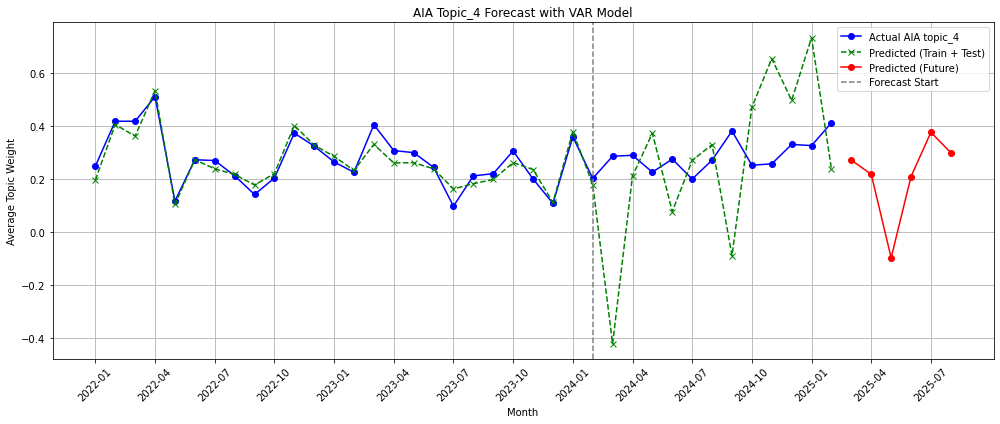

VAR Test RMSE: 0.3073, MAE: 0.2397


In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import VAR

# === 数据读取与处理 ===
companies = ['AIA', 'AXA', 'Manulife', 'Sun Life', 'Prudential']
company_files = [f"final_results/topics/{c}_doc_topic_matrix.csv" for c in companies]

monthly_features = None
for file, company in zip(company_files, companies):
    df = pd.read_csv(file)
    df['created_utc'] = pd.to_datetime(df['created_utc'], errors='coerce')
    df.dropna(subset=['created_utc'], inplace=True)
    df['month'] = df['created_utc'].dt.to_period('M')
    topic_cols = [col for col in df.columns if col.startswith("topic_")]
    monthly = df.groupby('month')[topic_cols].mean().reset_index()
    monthly['month'] = monthly['month'].astype(str)
    monthly.columns = ['month'] + [f"{company}_{col}" for col in topic_cols]
    monthly_features = monthly if monthly_features is None else pd.merge(monthly_features, monthly, on="month", how="outer")

monthly_features = monthly_features.sort_values("month").fillna(method="ffill").fillna(method="bfill")
monthly_features.index = pd.to_datetime(monthly_features['month'] + '-01')

# === 模型数据选择 ===
target = 'AIA_topic_4'
feature_cols = [col for col in monthly_features.columns if col.startswith(tuple(companies)) and col != target]
var_df = monthly_features[[target] + feature_cols].copy()

# === 训练/测试划分 ===
train_size = int(len(var_df) * 0.9)
train, test = var_df.iloc[:train_size], var_df.iloc[train_size:]

# === 模型拟合 ===
model = VAR(train)
results = model.fit(ic='aic')
lag_order = results.k_ar
print("Selected lag order:", lag_order)

# === 测试集预测 ===
forecast_input = train.values[-lag_order:]
forecast_test = results.forecast(y=forecast_input, steps=len(test))
forecast_df = pd.DataFrame(forecast_test, index=test.index, columns=var_df.columns)

# === 向未来预测（6个月）===
future_steps = 6
forecast_input_future = var_df.values[-lag_order:]
forecast_future = results.forecast(y=forecast_input_future, steps=future_steps)
future_index = pd.date_range(start=monthly_features.index[-1] + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS')
future_df = pd.DataFrame(forecast_future, index=future_index, columns=var_df.columns)

# === 构造可视化数据 ===
# 合并真实值（训练集去掉前 lag 部分 + 测试集全部）
y_actual = np.concatenate([
    train[target].iloc[lag_order:].to_numpy(),
    test[target].to_numpy()
])
x_all = np.concatenate([
    results.fittedvalues.index.to_numpy(dtype='datetime64[M]').astype(str),
    test.index.to_numpy(dtype='datetime64[M]').astype(str)
])

# 预测值（训练 + 测试）
x_pred_all = x_all.copy()
y_pred_total = np.concatenate([
    results.fittedvalues[target].to_numpy(),
    forecast_df[target].to_numpy()
])

# 未来预测
x_future = future_df.index.to_numpy(dtype='datetime64[M]').astype(str)
y_future = future_df[target].to_numpy()

# === 可视化部分 ===
start_cut = '2022-01'
mask_all = x_all >= start_cut
mask_pred = x_pred_all >= start_cut
mask_future = x_future >= start_cut

x_all = x_all[mask_all]
y_actual = y_actual[mask_all]
x_pred_all = x_pred_all[mask_pred]
y_pred_total = y_pred_total[mask_pred]
x_future = x_future[mask_future]
y_future = y_future[mask_future]

xticks_combined = np.concatenate([x_pred_all, x_future])
xtick_step = 3
xtick_labels = xticks_combined[::xtick_step]
xtick_positions = np.arange(0, len(xticks_combined), xtick_step)

plt.figure(figsize=(14, 6))
plt.plot(x_all, y_actual, label='Actual AIA topic_4', marker='o', color='blue')
plt.plot(x_pred_all, y_pred_total, label='Predicted (Train + Test)', linestyle='--', marker='x', color='green')
plt.plot(x_future, y_future, label='Predicted (Future)', marker='o', color='red')
plt.axvline(x=x_pred_all[-len(test)], color='gray', linestyle='--', label='Forecast Start')

plt.title("AIA Topic_4 Forecast with VAR Model")
plt.xlabel("Month")
plt.ylabel("Average Topic Weight")
plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 测试集指标评估 ===
y_true = test[target].values
y_pred = forecast_df[target].values
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print(f"VAR Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")


In [22]:
plt.savefig("forecast_aia_topic4_VAR_.png", dpi=300)

<Figure size 432x288 with 0 Axes>

In [37]:
 results.fittedvalues.index.to_numpy(dtype='datetime64[M]').astype(str)

array(['2014-03', '2014-04', '2014-09', '2014-10', '2014-11', '2014-12',
       '2015-01', '2015-02', '2015-04', '2015-06', '2015-07', '2015-08',
       '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02',
       '2016-03', '2016-04', '2016-05', '2016-08', '2016-09', '2016-11',
       '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-10', '2018-11', '2018-12', '2019-01',
       '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
       '2019-08', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02',
       '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08',
       '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02',
       '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08',
       '2021-09', '2021-10', '2021-11', '2021-12', 

Epoch 1/300


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_38412\2546574009.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_features = monthly_features.sort_values("month").fillna(method="ffill").fillna(method="bfill")
D:\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - loss: 0.2837 - val_loss: 0.0081
Epoch 2/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0635 - val_loss: 0.0288
Epoch 3/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0419 - val_loss: 0.0150
Epoch 4/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0349 - val_loss: 0.0196
Epoch 5/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0457 - val_loss: 0.0150
Epoch 6/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0309 - val_loss: 0.0164
Epoch 7/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0415 - val_loss: 0.0208
Epoch 8/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0443 - val_loss: 0.0209
Epoch 9/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0359 - val_loss: 0.0180
Epoch 10/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0397 - val_loss: 0.0134
Epoch 11/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0311 - val_loss: 0.0109
Epoch 12/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0387 - val

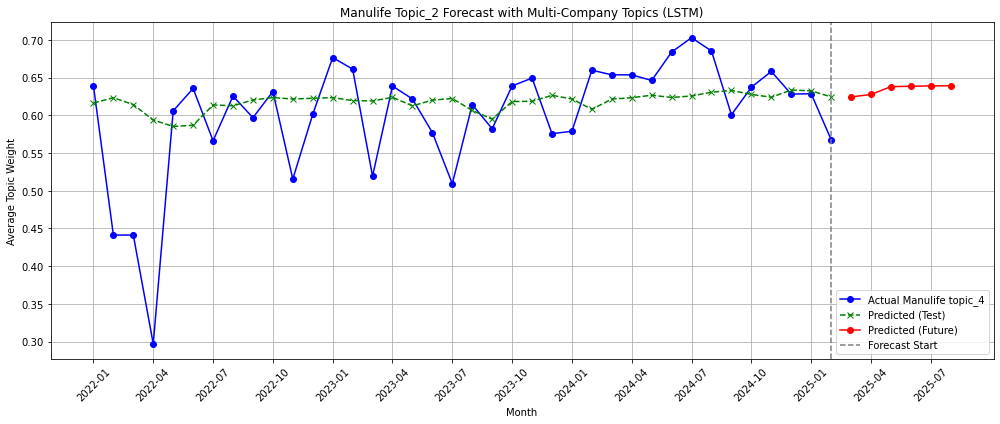

Test RMSE: 0.0422, MAE: 0.0360


In [90]:
# === 数据预处理 ===
monthly_features = monthly_features.sort_values("month").fillna(method="ffill").fillna(method="bfill")
feature_cols = [col for col in monthly_features.columns if col.startswith(tuple(companies)) and not col.startswith("Manulife_topic_4")]
target_col = "Manulife_topic_2"

X_raw = monthly_features[feature_cols].values
y_raw = monthly_features[target_col].values.reshape(-1, 1)

# === 归一化 ===
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# === 构建滑动窗口 ===
window =2
X, y = [], []
for i in range(len(X_scaled) - window):
    X.append(X_scaled[i:i+window])
    y.append(y_scaled[i+window])
X, y = np.array(X), np.array(y)

# === 划分训练/测试集 ===
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === LSTM 模型 ===
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(window, X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.fit(X_train, y_train, epochs=300, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# === 预测 ===
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# === 构造完整拟合序列（用于长时间可视化）===
full_y = scaler_y.inverse_transform(y_scaled[window:]).flatten()
pred_all = model.predict(X).flatten()
pred_all_inv = scaler_y.inverse_transform(pred_all.reshape(-1, 1)).flatten()

# === 构造未来6个月预测 ===
future_steps = 6
future_preds_scaled = []
last_seq = X[-1]

for _ in range(future_steps):
    next_pred = model.predict(last_seq.reshape(1, window, -1), verbose=0)[0][0]
    future_preds_scaled.append(next_pred)
    last_seq = np.vstack([last_seq[1:], np.append(next_pred, last_seq[-1, 1:])])

future_preds_inv = scaler_y.inverse_transform(
    np.c_[np.array(future_preds_scaled).reshape(-1, 1), np.zeros((future_steps, X.shape[2] - 1))]
)[:, 0]

# === 构造时间轴（从2022年开始）===
start_cut = '2022-01'
months = monthly_features['month'].iloc[window:].astype(str)
mask = months >= start_cut
x_show = months[mask].to_numpy()
y_actual_show = full_y[mask]
y_pred_show = pred_all_inv[mask]

# 未来月份
last_month_str = monthly_features['month'].iloc[-1]
last_month = pd.to_datetime(last_month_str + '-01')
future_months = pd.date_range(last_month + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS').strftime('%Y-%m').tolist()
x_future = np.array(future_months)
y_future = future_preds_inv

# === 可视化 ===
plt.figure(figsize=(14, 6))
plt.plot(x_show, y_actual_show, label='Actual Manulife topic_4', marker='o', color='blue')
plt.plot(x_show, y_pred_show, label='Predicted (Test)', linestyle='--', marker='x', color='green')
plt.plot(x_future, y_future, label='Predicted (Future)', marker='o', color='red')
plt.axvline(x=x_show[-1], color='gray', linestyle='--', label='Forecast Start')

plt.title("Manulife Topic_2 Forecast with Multi-Company Topics (LSTM)")
plt.xlabel("Month")
plt.ylabel("Average Topic Weight")

# 控制 x 轴密度（每3个点显示一次）
xticks_combined = np.concatenate([x_show, x_future])
plt.xticks(ticks=np.arange(0, len(xticks_combined), 3), labels=xticks_combined[::3], rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 误差 ===
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")


D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Selected lag order: 4


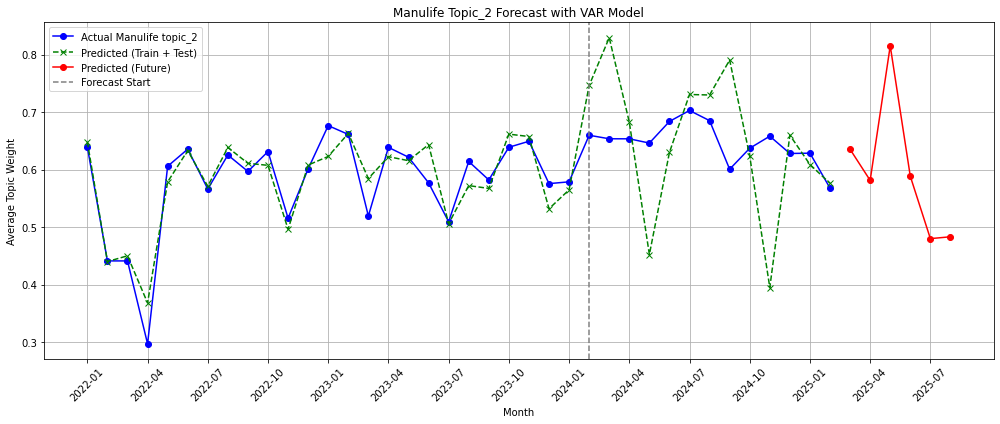

VAR Test RMSE: 0.1207, MAE: 0.0876


In [64]:

# === 模型数据选择 ===
target = 'Manulife_topic_2'
feature_cols = [col for col in monthly_features.columns if col.startswith(tuple(companies)) and col != target]
var_df = monthly_features[[target] + feature_cols].copy()

# === 训练/测试划分 ===
train_size = int(len(var_df) * 0.9)
train, test = var_df.iloc[:train_size], var_df.iloc[train_size:]

# === 模型拟合 ===
model = VAR(train)
results = model.fit(ic='aic')
lag_order = results.k_ar
print("Selected lag order:", lag_order)

# === 测试集预测 ===
forecast_input = train.values[-lag_order:]
forecast_test = results.forecast(y=forecast_input, steps=len(test))
forecast_df = pd.DataFrame(forecast_test, index=test.index, columns=var_df.columns)

# === 向未来预测（6个月）===
future_steps = 6
forecast_input_future = var_df.values[-lag_order:]
forecast_future = results.forecast(y=forecast_input_future, steps=future_steps)
future_index = pd.date_range(start=monthly_features.index[-1] + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS')
future_df = pd.DataFrame(forecast_future, index=future_index, columns=var_df.columns)

# === 构造可视化数据 ===
# 合并真实值（训练集去掉前 lag 部分 + 测试集全部）
y_actual = np.concatenate([
    train[target].iloc[lag_order:].to_numpy(),
    test[target].to_numpy()
])
x_all = np.concatenate([
    results.fittedvalues.index.to_numpy(dtype='datetime64[M]').astype(str),
    test.index.to_numpy(dtype='datetime64[M]').astype(str)
])

# 预测值（训练 + 测试）
x_pred_all = x_all.copy()
y_pred_total = np.concatenate([
    results.fittedvalues[target].to_numpy(),
    forecast_df[target].to_numpy()
])

# 未来预测
x_future = future_df.index.to_numpy(dtype='datetime64[M]').astype(str)
y_future = future_df[target].to_numpy()

# === 可视化部分 ===
start_cut = '2022-01'
mask_all = x_all >= start_cut
mask_pred = x_pred_all >= start_cut
mask_future = x_future >= start_cut

x_all = x_all[mask_all]
y_actual = y_actual[mask_all]
x_pred_all = x_pred_all[mask_pred]
y_pred_total = y_pred_total[mask_pred]
x_future = x_future[mask_future]
y_future = y_future[mask_future]

xticks_combined = np.concatenate([x_pred_all, x_future])
xtick_step = 3
xtick_labels = xticks_combined[::xtick_step]
xtick_positions = np.arange(0, len(xticks_combined), xtick_step)

plt.figure(figsize=(14, 6))
plt.plot(x_all, y_actual, label='Actual Manulife topic_2', marker='o', color='blue')
plt.plot(x_pred_all, y_pred_total, label='Predicted (Train + Test)', linestyle='--', marker='x', color='green')
plt.plot(x_future, y_future, label='Predicted (Future)', marker='o', color='red')
plt.axvline(x=x_pred_all[-len(test)], color='gray', linestyle='--', label='Forecast Start')

plt.title("Manulife Topic_2 Forecast with VAR Model")
plt.xlabel("Month")
plt.ylabel("Average Topic Weight")
plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 测试集指标评估 ===
y_true = test[target].values
y_pred = forecast_df[target].values
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print(f"VAR Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")


In [39]:
results.fittedvalues.index.to_numpy(dtype='datetime64[M]').astype(str)

array(['2014-03', '2014-04', '2014-09', '2014-10', '2014-11', '2014-12',
       '2015-01', '2015-02', '2015-04', '2015-06', '2015-07', '2015-08',
       '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02',
       '2016-03', '2016-04', '2016-05', '2016-08', '2016-09', '2016-11',
       '2016-12', '2017-01', '2017-02', '2017-03', '2017-04', '2017-05',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
       '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
       '2018-07', '2018-08', '2018-10', '2018-11', '2018-12', '2019-01',
       '2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
       '2019-08', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02',
       '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08',
       '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02',
       '2021-03', '2021-04', '2021-05', '2021-06', '2021-07', '2021-08',
       '2021-09', '2021-10', '2021-11', '2021-12', 

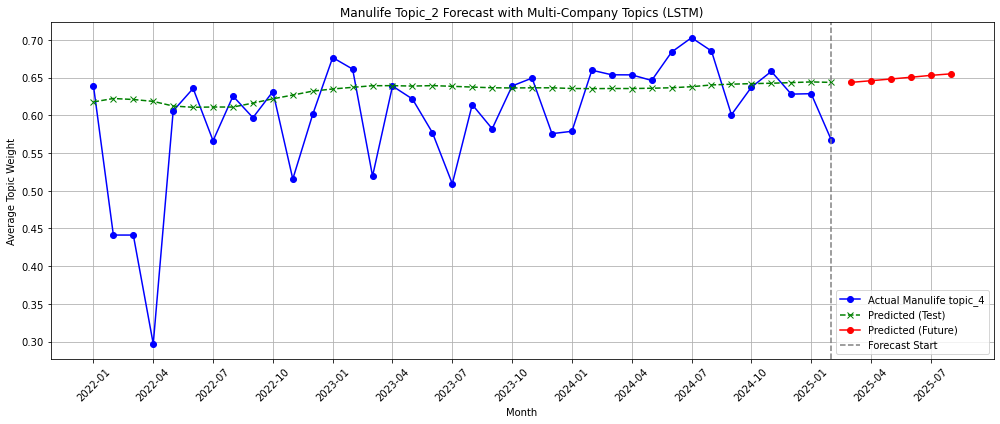

Test RMSE: 0.0381, MAE: 0.0310


In [64]:
# === 可视化 ===
plt.figure(figsize=(14, 6))
plt.plot(x_show, y_actual_show, label='Actual Manulife topic_2', marker='o', color='blue')
plt.plot(x_show, y_pred_show, label='Predicted (Test)', linestyle='--', marker='x', color='green')
plt.plot(x_future, y_future, label='Predicted (Future)', marker='o', color='red')
plt.axvline(x=x_show[-1], color='gray', linestyle='--', label='Forecast Start')
plt.title("Manulife Topic_2 Forecast with Multi-Company Topics (LSTM)")
plt.xlabel("Month")
plt.ylabel("Average Topic Weight")

# 控制 x 轴密度（每3个点显示一次）
xticks_combined = np.concatenate([x_show, x_future])
plt.xticks(ticks=np.arange(0, len(xticks_combined), 3), labels=xticks_combined[::3], rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 误差 ===
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")


In [ ]:
# === 选择目标变量与特征 ===
target = 'Manulife_topic_2'
feature_cols = [col for col in monthly_features.columns if col.startswith(tuple(companies)) and not col == target]

var_df = monthly_features[[target] + feature_cols].copy()

# === 数据划分 ===
train_size = int(len(var_df) * 0.9)
train, test = var_df.iloc[:train_size], var_df.iloc[train_size:]

# === VAR 模型拟合与预测（自动选阶） ===
model = VAR(train)
results = model.fit(ic='aic')
lag_order = results.k_ar
print("Selected lag order:", lag_order)

forecast_input = train.values[-lag_order:]
forecast = results.forecast(y=forecast_input, steps=len(test))
forecast_df = pd.DataFrame(forecast, index=test.index, columns=var_df.columns)

# === 正确提取拟合和实际值（对齐长度） ===
x_all = results.fittedvalues.index.to_numpy(dtype='datetime64[M]').astype(str)
y_pred_all = results.fittedvalues[target].to_numpy()
y_actual = train[target].iloc[lag_order:].to_numpy()

x_test = forecast_df.index.to_numpy(dtype='datetime64[M]').astype(str)
y_pred_test = forecast_df[target].to_numpy()

# === 对齐起点到 2022-01 ===
start_cut = '2022-01'
mask_all = x_all >= start_cut
mask_test = x_test >= start_cut

x_all = x_all[mask_all]
y_actual = y_actual[mask_all]
y_pred_all = y_pred_all[mask_all]

x_test = x_test[mask_test]
y_pred_test = y_pred_test[mask_test]

# 与 LSTM 图保持时间刻度一致（每3个月显示一次）
xticks_combined = np.concatenate([x_all, x_test])
xtick_step = 3
xtick_labels = xticks_combined[::xtick_step]
xtick_positions = np.arange(0, len(xticks_combined), xtick_step)

plt.figure(figsize=(14, 6))
plt.plot(x_all, y_actual[:len(x_all)], label='Actual Manulife topic_4', marker='o', color='blue')
plt.plot(x_all, y_pred_all, label='Fitted (In-Sample)', linestyle='--', marker='x', color='green')
plt.plot(x_test, y_pred_test, label='Forecast (Out-of-Sample)', marker='o', color='red')
if len(x_test) > 0:
    plt.axvline(x=x_test[0], color='gray', linestyle='--', label='Forecast Start')

plt.title("Manulife Topic_2 Forecast with VAR Model")
plt.xlabel("Month")
plt.ylabel("Average Topic Weight")
plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 误差评估 ===
y_true = test[target].values
y_pred = forecast_df[target].values
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print(f"VAR Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")


In [65]:
plt.savefig("forecast_manulife_topic2.png", dpi=300)

<Figure size 432x288 with 0 Axes>

In [40]:
plt.savefig("forecast_manulife_topic2_VAR.png", dpi=300)

<Figure size 432x288 with 0 Axes>

Epoch 1/300


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_38412\6966234.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_features = monthly_features.sort_values("month").fillna(method="ffill").fillna(method="bfill")
D:\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - loss: 0.0821 - val_loss: 0.0063
Epoch 2/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0499 - val_loss: 0.0150
Epoch 3/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0494 - val_loss: 0.0092
Epoch 4/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0520 - val_loss: 0.0064
Epoch 5/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0399 - val_loss: 0.0066
Epoch 6/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0401 - val_loss: 0.0064
Epoch 7/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0361 - val_loss: 0.0058
Epoch 8/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0352 - val_loss: 0.0142
Epoch 9/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0400 - val_loss: 0.0072
Epoch 10/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0305 - val_loss: 0.0265
Epoch 11/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0436 - val_loss: 0.0066
Epoch 12/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0

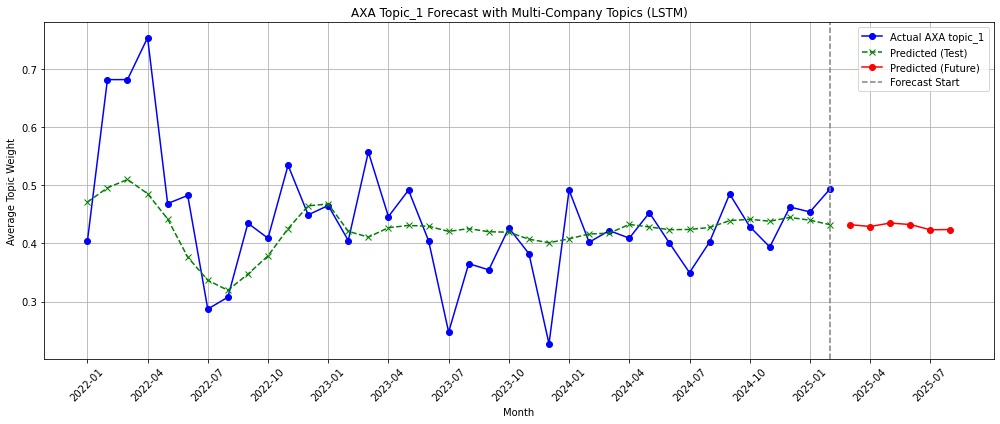

Test RMSE: 0.0370, MAE: 0.0309


In [85]:
# === 数据预处理 ===
monthly_features = monthly_features.sort_values("month").fillna(method="ffill").fillna(method="bfill")
feature_cols = [col for col in monthly_features.columns if col.startswith(tuple(companies)) and not col.startswith("AXA_topic_4")]
target_col = "AXA_topic_1"

X_raw = monthly_features[feature_cols].values
y_raw = monthly_features[target_col].values.reshape(-1, 1)

# === 归一化 ===
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# === 构建滑动窗口 ===
window = 6
X, y = [], []
for i in range(len(X_scaled) - window):
    X.append(X_scaled[i:i+window])
    y.append(y_scaled[i+window])
X, y = np.array(X), np.array(y)

# === 划分训练/测试集 ===
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === LSTM 模型 ===
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(window, X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.fit(X_train, y_train, epochs=300, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# === 预测 ===
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# === 构造完整拟合序列（用于长时间可视化）===
full_y = scaler_y.inverse_transform(y_scaled[window:]).flatten()
pred_all = model.predict(X).flatten()
pred_all_inv = scaler_y.inverse_transform(pred_all.reshape(-1, 1)).flatten()

# === 构造未来6个月预测 ===
future_steps = 6
future_preds_scaled = []
last_seq = X[-1]

for _ in range(future_steps):
    next_pred = model.predict(last_seq.reshape(1, window, -1), verbose=0)[0][0]
    future_preds_scaled.append(next_pred)
    last_seq = np.vstack([last_seq[1:], np.append(next_pred, last_seq[-1, 1:])])

future_preds_inv = scaler_y.inverse_transform(
    np.c_[np.array(future_preds_scaled).reshape(-1, 1), np.zeros((future_steps, X.shape[2] - 1))]
)[:, 0]

# === 构造时间轴（从2022年开始）===
start_cut = '2022-01'
months = monthly_features['month'].iloc[window:].astype(str)
mask = months >= start_cut
x_show = months[mask].to_numpy()
y_actual_show = full_y[mask]
y_pred_show = pred_all_inv[mask]

# 未来月份
last_month_str = monthly_features['month'].iloc[-1]
last_month = pd.to_datetime(last_month_str + '-01')
future_months = pd.date_range(last_month + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS').strftime('%Y-%m').tolist()
x_future = np.array(future_months)
y_future = future_preds_inv

# === 可视化 ===
plt.figure(figsize=(14, 6))
plt.plot(x_show, y_actual_show, label='Actual AXA topic_1', marker='o', color='blue')
plt.plot(x_show, y_pred_show, label='Predicted (Test)', linestyle='--', marker='x', color='green')
plt.plot(x_future, y_future, label='Predicted (Future)', marker='o', color='red')
plt.axvline(x=x_show[-1], color='gray', linestyle='--', label='Forecast Start')

plt.title("AXA Topic_1 Forecast with Multi-Company Topics (LSTM)")
plt.xlabel("Month")
plt.ylabel("Average Topic Weight")

# 控制 x 轴密度（每3个点显示一次）
xticks_combined = np.concatenate([x_show, x_future])
plt.xticks(ticks=np.arange(0, len(xticks_combined), 3), labels=xticks_combined[::3], rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 误差 ===
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")


In [86]:
plt.savefig("forecast_axa_topic1.png", dpi=300)

<Figure size 432x288 with 0 Axes>

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Selected lag order: 4


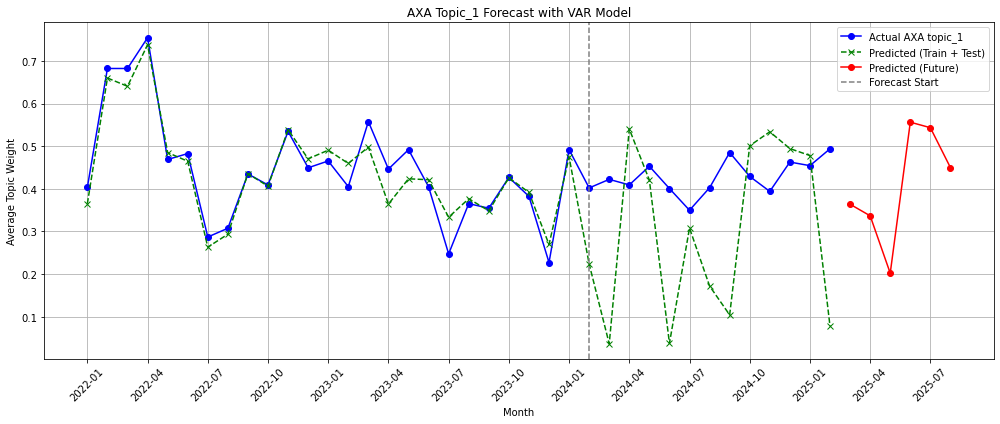

VAR Test RMSE: 0.2370, MAE: 0.1867


In [65]:

# === 模型数据选择 ===
target = 'AXA_topic_1'
feature_cols = [col for col in monthly_features.columns if col.startswith(tuple(companies)) and col != target]
var_df = monthly_features[[target] + feature_cols].copy()

# === 训练/测试划分 ===
train_size = int(len(var_df) * 0.9)
train, test = var_df.iloc[:train_size], var_df.iloc[train_size:]

# === 模型拟合 ===
model = VAR(train)
results = model.fit(ic='aic')
lag_order = results.k_ar
print("Selected lag order:", lag_order)

# === 测试集预测 ===
forecast_input = train.values[-lag_order:]
forecast_test = results.forecast(y=forecast_input, steps=len(test))
forecast_df = pd.DataFrame(forecast_test, index=test.index, columns=var_df.columns)

# === 向未来预测（6个月）===
future_steps = 6
forecast_input_future = var_df.values[-lag_order:]
forecast_future = results.forecast(y=forecast_input_future, steps=future_steps)
future_index = pd.date_range(start=monthly_features.index[-1] + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS')
future_df = pd.DataFrame(forecast_future, index=future_index, columns=var_df.columns)

# === 构造可视化数据 ===
# 合并真实值（训练集去掉前 lag 部分 + 测试集全部）
y_actual = np.concatenate([
    train[target].iloc[lag_order:].to_numpy(),
    test[target].to_numpy()
])
x_all = np.concatenate([
    results.fittedvalues.index.to_numpy(dtype='datetime64[M]').astype(str),
    test.index.to_numpy(dtype='datetime64[M]').astype(str)
])

# 预测值（训练 + 测试）
x_pred_all = x_all.copy()
y_pred_total = np.concatenate([
    results.fittedvalues[target].to_numpy(),
    forecast_df[target].to_numpy()
])

# 未来预测
x_future = future_df.index.to_numpy(dtype='datetime64[M]').astype(str)
y_future = future_df[target].to_numpy()

# === 可视化部分 ===
start_cut = '2022-01'
mask_all = x_all >= start_cut
mask_pred = x_pred_all >= start_cut
mask_future = x_future >= start_cut

x_all = x_all[mask_all]
y_actual = y_actual[mask_all]
x_pred_all = x_pred_all[mask_pred]
y_pred_total = y_pred_total[mask_pred]
x_future = x_future[mask_future]
y_future = y_future[mask_future]

xticks_combined = np.concatenate([x_pred_all, x_future])
xtick_step = 3
xtick_labels = xticks_combined[::xtick_step]
xtick_positions = np.arange(0, len(xticks_combined), xtick_step)

plt.figure(figsize=(14, 6))
plt.plot(x_all, y_actual, label='Actual AXA topic_1', marker='o', color='blue')
plt.plot(x_pred_all, y_pred_total, label='Predicted (Train + Test)', linestyle='--', marker='x', color='green')
plt.plot(x_future, y_future, label='Predicted (Future)', marker='o', color='red')
plt.axvline(x=x_pred_all[-len(test)], color='gray', linestyle='--', label='Forecast Start')

plt.title("AXA Topic_1 Forecast with VAR Model")
plt.xlabel("Month")
plt.ylabel("Average Topic Weight")
plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 测试集指标评估 ===
y_true = test[target].values
y_pred = forecast_df[target].values
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print(f"VAR Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")


In [42]:
plt.savefig("forecast_axa_topic1_VAR.png", dpi=300)

<Figure size 432x288 with 0 Axes>

In [74]:
monthly_features.head()

,month,AIA_topic_0,AIA_topic_1,AIA_topic_2,AIA_topic_3,AIA_topic_4,AXA_topic_0,AXA_topic_1,AXA_topic_2,AXA_topic_3,...,Manulife_topic_2,Manulife_topic_3,Sun Life_topic_0,Sun Life_topic_1,Sun Life_topic_2,Prudential_topic_0,Prudential_topic_1,Prudential_topic_2,Prudential_topic_3,Prudential_topic_4
0,2011-10,0.038976,0.085329,0.091306,0.112849,0.668904,0.115774,0.451038,0.389787,0.043401,...,0.470971,0.195873,0.290784,0.170836,0.538381,0.111555,0.499056,0.137059,0.1333,0.118518
1,2012-10,0.038976,0.085329,0.091306,0.112849,0.668904,0.115774,0.451038,0.389787,0.043401,...,0.470971,0.195873,0.290784,0.170836,0.538381,0.111555,0.499056,0.137059,0.1333,0.118518
2,2013-03,0.038976,0.085329,0.091306,0.112849,0.668904,0.115774,0.451038,0.389787,0.043401,...,0.470971,0.195873,0.153278,0.169911,0.676811,0.111555,0.499056,0.137059,0.1333,0.118518
3,2013-10,0.038976,0.085329,0.091306,0.112849,0.668904,0.115774,0.451038,0.389787,0.043401,...,0.470971,0.195873,0.124879,0.170087,0.705034,0.111555,0.499056,0.137059,0.1333,0.118518
4,2014-03,0.038976,0.085329,0.091306,0.112849,0.668904,0.115774,0.451038,0.389787,0.043401,...,0.470971,0.195873,0.124879,0.170087,0.705034,0.111555,0.499056,0.137059,0.1333,0.118518


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_38412\1510254610.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_features = monthly_features.sort_values("month").fillna(method="ffill").fillna(method="bfill")
D:\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.2169 - val_loss: 0.0065
Epoch 2/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0270 - val_loss: 0.0062
Epoch 3/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0195 - val_loss: 0.0018
Epoch 4/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0218 - val_loss: 4.3527e-04
Epoch 5/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0280 - val_loss: 4.2966e-04
Epoch 6/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0178 - val_loss: 0.0011
Epoch 7/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0199 - val_loss: 0.0012
Epoch 8/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0130 - val_loss: 0.0030
Epoch 9/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0211 - val_loss: 7.7342e-04
Epoch 10/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0142 - val_loss: 0.0042
Epoch 11/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0139 - val_loss: 0.0010
Epoch 12/300
14/14 ━━━━━━━━━━━━━━━━━━━━ 

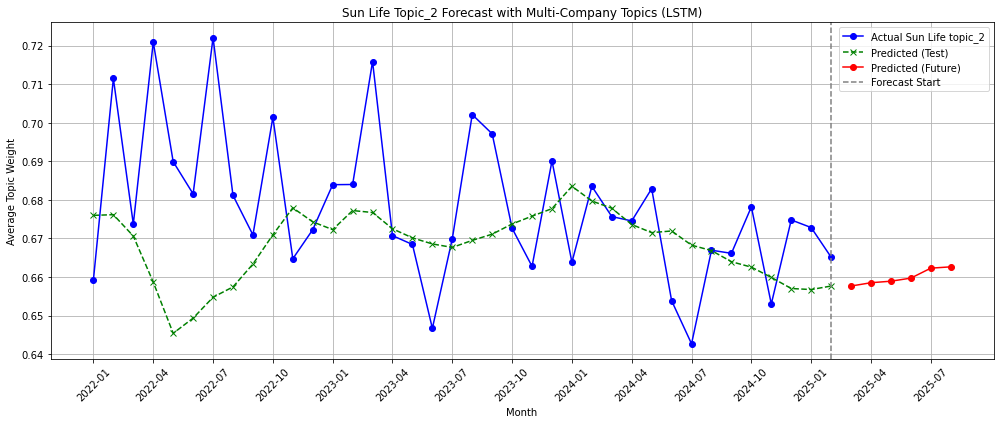

Test RMSE: 0.0130, MAE: 0.0104


In [83]:
# === 数据预处理 ===
monthly_features = monthly_features.sort_values("month").fillna(method="ffill").fillna(method="bfill")
feature_cols = [col for col in monthly_features.columns if col.startswith(tuple(companies)) and not col.startswith("Sun Life_topic_4")]
target_col = "Sun Life_topic_2"

X_raw = monthly_features[feature_cols].values
y_raw = monthly_features[target_col].values.reshape(-1, 1)

# === 归一化 ===
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# === 构建滑动窗口 ===
window = 6
X, y = [], []
for i in range(len(X_scaled) - window):
    X.append(X_scaled[i:i+window])
    y.append(y_scaled[i+window])
X, y = np.array(X), np.array(y)

# === 划分训练/测试集 ===
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === LSTM 模型 ===
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(window, X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.fit(X_train, y_train, epochs=300, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# === 预测 ===
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# === 构造完整拟合序列（用于长时间可视化）===
full_y = scaler_y.inverse_transform(y_scaled[window:]).flatten()
pred_all = model.predict(X).flatten()
pred_all_inv = scaler_y.inverse_transform(pred_all.reshape(-1, 1)).flatten()

# === 构造未来6个月预测 ===
future_steps = 6
future_preds_scaled = []
last_seq = X[-1]

for _ in range(future_steps):
    next_pred = model.predict(last_seq.reshape(1, window, -1), verbose=0)[0][0]
    future_preds_scaled.append(next_pred)
    last_seq = np.vstack([last_seq[1:], np.append(next_pred, last_seq[-1, 1:])])

future_preds_inv = scaler_y.inverse_transform(
    np.c_[np.array(future_preds_scaled).reshape(-1, 1), np.zeros((future_steps, X.shape[2] - 1))]
)[:, 0]

# === 构造时间轴（从2022年开始）===
start_cut = '2022-01'
months = monthly_features['month'].iloc[window:].astype(str)
mask = months >= start_cut
x_show = months[mask].to_numpy()
y_actual_show = full_y[mask]
y_pred_show = pred_all_inv[mask]

# 未来月份
last_month_str = monthly_features['month'].iloc[-1]
last_month = pd.to_datetime(last_month_str + '-01')
future_months = pd.date_range(last_month + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS').strftime('%Y-%m').tolist()
x_future = np.array(future_months)
y_future = future_preds_inv

# === 可视化 ===
plt.figure(figsize=(14, 6))
plt.plot(x_show, y_actual_show, label='Actual Sun Life topic_2', marker='o', color='blue')
plt.plot(x_show, y_pred_show, label='Predicted (Test)', linestyle='--', marker='x', color='green')
plt.plot(x_future, y_future, label='Predicted (Future)', marker='o', color='red')
plt.axvline(x=x_show[-1], color='gray', linestyle='--', label='Forecast Start')

plt.title("Sun Life Topic_2 Forecast with Multi-Company Topics (LSTM)")
plt.xlabel("Month")
plt.ylabel("Average Topic Weight")

# 控制 x 轴密度（每3个点显示一次）
xticks_combined = np.concatenate([x_show, x_future])
plt.xticks(ticks=np.arange(0, len(xticks_combined), 3), labels=xticks_combined[::3], rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 误差 ===
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")


In [84]:
plt.savefig("forecast_SunLife_topic2.png", dpi=300)

<Figure size 432x288 with 0 Axes>

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Selected lag order: 4


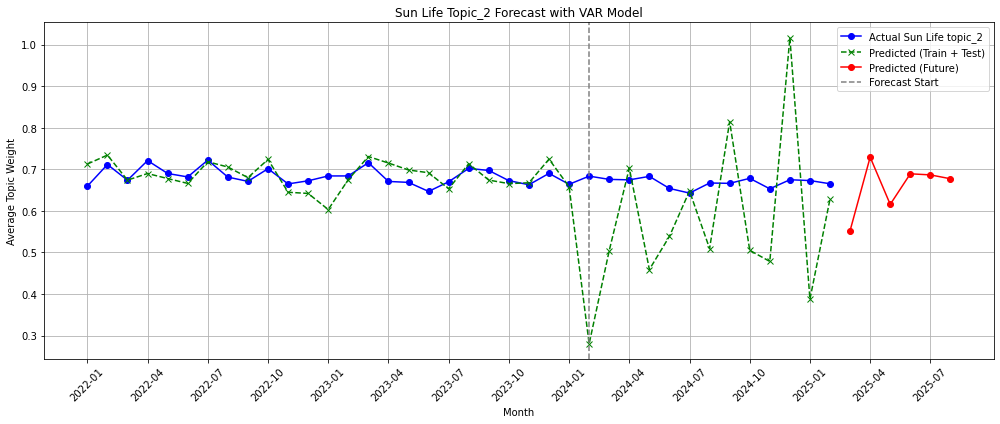

VAR Test RMSE: 0.2082, MAE: 0.1743


In [66]:

# === 模型数据选择 ===
target = 'Sun Life_topic_2'
feature_cols = [col for col in monthly_features.columns if col.startswith(tuple(companies)) and col != target]
var_df = monthly_features[[target] + feature_cols].copy()

# === 训练/测试划分 ===
train_size = int(len(var_df) * 0.9)
train, test = var_df.iloc[:train_size], var_df.iloc[train_size:]

# === 模型拟合 ===
model = VAR(train)
results = model.fit(ic='aic')
lag_order = results.k_ar
print("Selected lag order:", lag_order)

# === 测试集预测 ===
forecast_input = train.values[-lag_order:]
forecast_test = results.forecast(y=forecast_input, steps=len(test))
forecast_df = pd.DataFrame(forecast_test, index=test.index, columns=var_df.columns)

# === 向未来预测（6个月）===
future_steps = 6
forecast_input_future = var_df.values[-lag_order:]
forecast_future = results.forecast(y=forecast_input_future, steps=future_steps)
future_index = pd.date_range(start=monthly_features.index[-1] + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS')
future_df = pd.DataFrame(forecast_future, index=future_index, columns=var_df.columns)

# === 构造可视化数据 ===
# 合并真实值（训练集去掉前 lag 部分 + 测试集全部）
y_actual = np.concatenate([
    train[target].iloc[lag_order:].to_numpy(),
    test[target].to_numpy()
])
x_all = np.concatenate([
    results.fittedvalues.index.to_numpy(dtype='datetime64[M]').astype(str),
    test.index.to_numpy(dtype='datetime64[M]').astype(str)
])

# 预测值（训练 + 测试）
x_pred_all = x_all.copy()
y_pred_total = np.concatenate([
    results.fittedvalues[target].to_numpy(),
    forecast_df[target].to_numpy()
])

# 未来预测
x_future = future_df.index.to_numpy(dtype='datetime64[M]').astype(str)
y_future = future_df[target].to_numpy()

# === 可视化部分 ===
start_cut = '2022-01'
mask_all = x_all >= start_cut
mask_pred = x_pred_all >= start_cut
mask_future = x_future >= start_cut

x_all = x_all[mask_all]
y_actual = y_actual[mask_all]
x_pred_all = x_pred_all[mask_pred]
y_pred_total = y_pred_total[mask_pred]
x_future = x_future[mask_future]
y_future = y_future[mask_future]

xticks_combined = np.concatenate([x_pred_all, x_future])
xtick_step = 3
xtick_labels = xticks_combined[::xtick_step]
xtick_positions = np.arange(0, len(xticks_combined), xtick_step)

plt.figure(figsize=(14, 6))
plt.plot(x_all, y_actual, label='Actual Sun Life topic_2', marker='o', color='blue')
plt.plot(x_pred_all, y_pred_total, label='Predicted (Train + Test)', linestyle='--', marker='x', color='green')
plt.plot(x_future, y_future, label='Predicted (Future)', marker='o', color='red')
plt.axvline(x=x_pred_all[-len(test)], color='gray', linestyle='--', label='Forecast Start')

plt.title("Sun Life Topic_2 Forecast with VAR Model")
plt.xlabel("Month")
plt.ylabel("Average Topic Weight")
plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 测试集指标评估 ===
y_true = test[target].values
y_pred = forecast_df[target].values
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print(f"VAR Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")


In [45]:
plt.savefig("forecast_SunLife_topic2_VAR.png", dpi=300)

<Figure size 432x288 with 0 Axes>

Epoch 1/300


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_38412\3193703024.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_features = monthly_features.sort_values("month").fillna(method="ffill").fillna(method="bfill")
D:\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.1175 - val_loss: 0.0071
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0549 - val_loss: 0.0076
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0597 - val_loss: 0.0093
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0464 - val_loss: 0.0225
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0366 - val_loss: 0.0204
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0381 - val_loss: 0.0065
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0454 - val_loss: 0.0458
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0439 - val_loss: 0.0080
Epoch 9/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0266 - val_loss: 0.0107
Epoch 10/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0408 - val_loss: 0.0223
Epoch 11/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0336 - val_loss: 0.0066
Epoch 12/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0

Epoch 69/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0286 - val_loss: 0.0123
Epoch 70/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0320 - val_loss: 0.0262
Epoch 71/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0301 - val_loss: 0.0128
Epoch 72/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0249 - val_loss: 0.0112
Epoch 73/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0223 - val_loss: 0.0147
Epoch 74/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0268 - val_loss: 0.0235
Epoch 75/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0285 - val_loss: 0.0258
Epoch 76/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0284 - val_loss: 0.0150
Epoch 77/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0297 - val_loss: 0.0227
Epoch 78/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0270 - val_loss: 0.0315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  


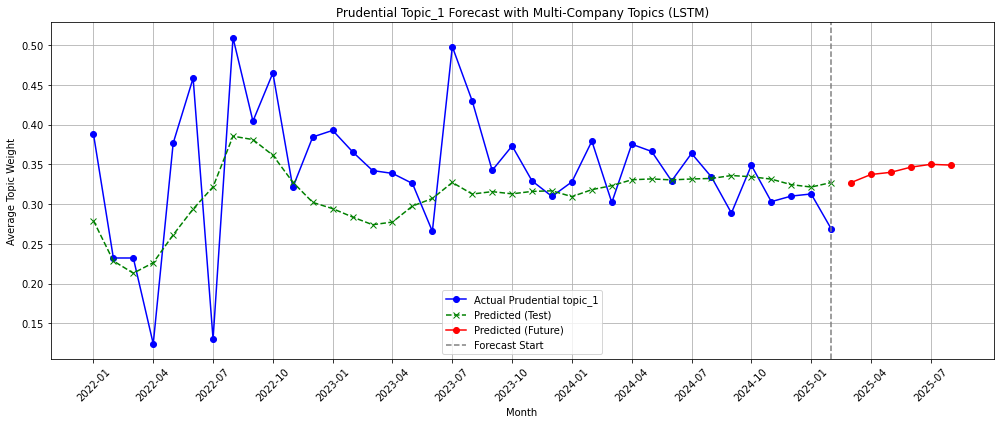

Test RMSE: 0.0311, MAE: 0.0256


In [81]:
# === 数据预处理 ===
monthly_features = monthly_features.sort_values("month").fillna(method="ffill").fillna(method="bfill")
feature_cols = [col for col in monthly_features.columns if col.startswith(tuple(companies)) and not col.startswith("Prudential_topic_4")]
target_col = "Prudential_topic_1"

X_raw = monthly_features[feature_cols].values
y_raw = monthly_features[target_col].values.reshape(-1, 1)

# === 归一化 ===
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# === 构建滑动窗口 ===
window = 12
X, y = [], []
for i in range(len(X_scaled) - window):
    X.append(X_scaled[i:i+window])
    y.append(y_scaled[i+window])
X, y = np.array(X), np.array(y)

# === 划分训练/测试集 ===
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === LSTM 模型 ===
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(window, X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.fit(X_train, y_train, epochs=300, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=1)

# === 预测 ===
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# === 构造完整拟合序列（用于长时间可视化）===
full_y = scaler_y.inverse_transform(y_scaled[window:]).flatten()
pred_all = model.predict(X).flatten()
pred_all_inv = scaler_y.inverse_transform(pred_all.reshape(-1, 1)).flatten()

# === 构造未来6个月预测 ===
future_steps = 6
future_preds_scaled = []
last_seq = X[-1]

for _ in range(future_steps):
    next_pred = model.predict(last_seq.reshape(1, window, -1), verbose=0)[0][0]
    future_preds_scaled.append(next_pred)
    last_seq = np.vstack([last_seq[1:], np.append(next_pred, last_seq[-1, 1:])])

future_preds_inv = scaler_y.inverse_transform(
    np.c_[np.array(future_preds_scaled).reshape(-1, 1), np.zeros((future_steps, X.shape[2] - 1))]
)[:, 0]

# === 构造时间轴（从2022年开始）===
start_cut = '2022-01'
months = monthly_features['month'].iloc[window:].astype(str)
mask = months >= start_cut
x_show = months[mask].to_numpy()
y_actual_show = full_y[mask]
y_pred_show = pred_all_inv[mask]

# 未来月份
last_month_str = monthly_features['month'].iloc[-1]
last_month = pd.to_datetime(last_month_str + '-01')
future_months = pd.date_range(last_month + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS').strftime('%Y-%m').tolist()
x_future = np.array(future_months)
y_future = future_preds_inv

# === 可视化 ===
plt.figure(figsize=(14, 6))
plt.plot(x_show, y_actual_show, label='Actual Prudential topic_1', marker='o', color='blue')
plt.plot(x_show, y_pred_show, label='Predicted (Test)', linestyle='--', marker='x', color='green')
plt.plot(x_future, y_future, label='Predicted (Future)', marker='o', color='red')
plt.axvline(x=x_show[-1], color='gray', linestyle='--', label='Forecast Start')

plt.title("Prudential Topic_1 Forecast with Multi-Company Topics (LSTM)")
plt.xlabel("Month")
plt.ylabel("Average Topic Weight")

# 控制 x 轴密度（每3个点显示一次）
xticks_combined = np.concatenate([x_show, x_future])
plt.xticks(ticks=np.arange(0, len(xticks_combined), 3), labels=xticks_combined[::3], rotation=45)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 误差 ===
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")


In [82]:
plt.savefig("forecast_Prudential1_topic1.png", dpi=300)

<Figure size 432x288 with 0 Axes>

D:\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Selected lag order: 4


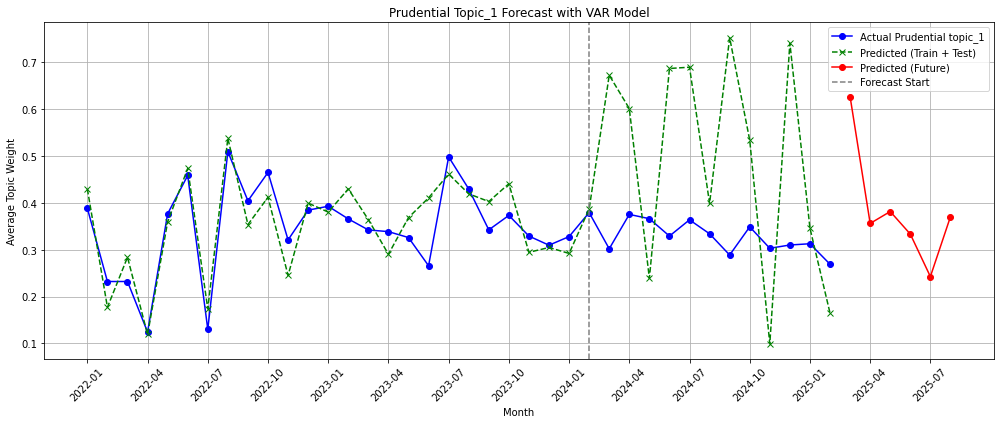

VAR Test RMSE: 0.2677, MAE: 0.2232


In [67]:

# === 模型数据选择 ===
target = 'Prudential_topic_1'
feature_cols = [col for col in monthly_features.columns if col.startswith(tuple(companies)) and col != target]
var_df = monthly_features[[target] + feature_cols].copy()

# === 训练/测试划分 ===
train_size = int(len(var_df) * 0.9)
train, test = var_df.iloc[:train_size], var_df.iloc[train_size:]

# === 模型拟合 ===
model = VAR(train)
results = model.fit(ic='aic')
lag_order = results.k_ar
print("Selected lag order:", lag_order)

# === 测试集预测 ===
forecast_input = train.values[-lag_order:]
forecast_test = results.forecast(y=forecast_input, steps=len(test))
forecast_df = pd.DataFrame(forecast_test, index=test.index, columns=var_df.columns)

# === 向未来预测（6个月）===
future_steps = 6
forecast_input_future = var_df.values[-lag_order:]
forecast_future = results.forecast(y=forecast_input_future, steps=future_steps)
future_index = pd.date_range(start=monthly_features.index[-1] + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS')
future_df = pd.DataFrame(forecast_future, index=future_index, columns=var_df.columns)

# === 构造可视化数据 ===
# 合并真实值（训练集去掉前 lag 部分 + 测试集全部）
y_actual = np.concatenate([
    train[target].iloc[lag_order:].to_numpy(),
    test[target].to_numpy()
])
x_all = np.concatenate([
    results.fittedvalues.index.to_numpy(dtype='datetime64[M]').astype(str),
    test.index.to_numpy(dtype='datetime64[M]').astype(str)
])

# 预测值（训练 + 测试）
x_pred_all = x_all.copy()
y_pred_total = np.concatenate([
    results.fittedvalues[target].to_numpy(),
    forecast_df[target].to_numpy()
])

# 未来预测
x_future = future_df.index.to_numpy(dtype='datetime64[M]').astype(str)
y_future = future_df[target].to_numpy()

# === 可视化部分 ===
start_cut = '2022-01'
mask_all = x_all >= start_cut
mask_pred = x_pred_all >= start_cut
mask_future = x_future >= start_cut

x_all = x_all[mask_all]
y_actual = y_actual[mask_all]
x_pred_all = x_pred_all[mask_pred]
y_pred_total = y_pred_total[mask_pred]
x_future = x_future[mask_future]
y_future = y_future[mask_future]

xticks_combined = np.concatenate([x_pred_all, x_future])
xtick_step = 3
xtick_labels = xticks_combined[::xtick_step]
xtick_positions = np.arange(0, len(xticks_combined), xtick_step)

plt.figure(figsize=(14, 6))
plt.plot(x_all, y_actual, label='Actual Prudential topic_1', marker='o', color='blue')
plt.plot(x_pred_all, y_pred_total, label='Predicted (Train + Test)', linestyle='--', marker='x', color='green')
plt.plot(x_future, y_future, label='Predicted (Future)', marker='o', color='red')
plt.axvline(x=x_pred_all[-len(test)], color='gray', linestyle='--', label='Forecast Start')

plt.title("Prudential Topic_1 Forecast with VAR Model")
plt.xlabel("Month")
plt.ylabel("Average Topic Weight")
plt.xticks(ticks=xtick_positions, labels=xtick_labels, rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 测试集指标评估 ===
y_true = test[target].values
y_pred = forecast_df[target].values
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print(f"VAR Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")


In [47]:
plt.savefig("forecast_Prudential1_topic1_VAR.png", dpi=300)

<Figure size 432x288 with 0 Axes>

# LSTM+VAR

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_3144\1050646077.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  monthly_features = monthly_features.sort_values("month").fillna(method="ffill").fillna(method="bfill").reset_index(drop=True)
D:\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


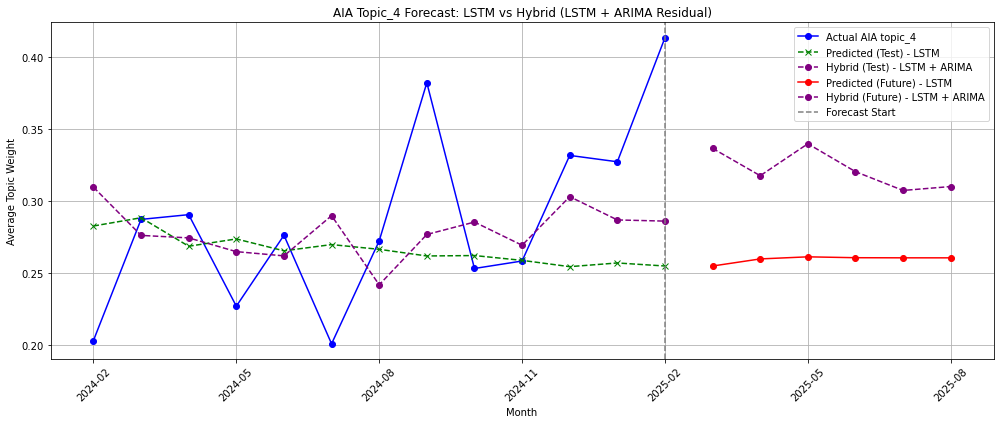

LSTM Test RMSE: 0.0704, MAE: 0.0516
Hybrid Test RMSE: 0.0639, MAE: 0.0500


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA

# === 读取数据 ===
companies = ['AIA', 'AXA', 'Manulife', 'Sun Life', 'Prudential']
company_files = [f"final_results/topics/{c}_doc_topic_matrix.csv" for c in companies]

monthly_features = None
for file, company in zip(company_files, companies):
    df = pd.read_csv(file)
    df['created_utc'] = pd.to_datetime(df['created_utc'], errors='coerce')
    df.dropna(subset=['created_utc'], inplace=True)
    df['month'] = df['created_utc'].dt.to_period('M')
    topic_cols = [col for col in df.columns if col.startswith("topic_")]
    monthly = df.groupby('month')[topic_cols].mean().reset_index()
    monthly['month'] = monthly['month'].astype(str)
    monthly.columns = ['month'] + [f"{company}_{col}" for col in topic_cols]
    monthly_features = monthly if monthly_features is None else pd.merge(monthly_features, monthly, on="month", how="outer")

# === 数据预处理 ===
monthly_features = monthly_features.sort_values("month").fillna(method="ffill").fillna(method="bfill").reset_index(drop=True)
feature_cols = [col for col in monthly_features.columns if col.startswith(tuple(companies)) and not col.startswith("AIA_topic_4")]
target_col = "AIA_topic_4"

X_raw = monthly_features[feature_cols].values
y_raw = monthly_features[target_col].values.reshape(-1, 1)

# === 归一化 ===
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# === 构建滑动窗口 ===
window = 3
X, y = [], []
for i in range(len(X_scaled) - window):
    X.append(X_scaled[i:i+window])
    y.append(y_scaled[i+window])
X, y = np.array(X), np.array(y)

# === 划分训练/测试集 ===
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# === LSTM 模型 ===
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(window, X.shape[2])))
model.add(Dropout(0.3))
model.add(LSTM(64))
model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model.fit(X_train, y_train, epochs=300, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stop], verbose=0)

# === 预测 ===
y_pred = model.predict(X_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_test)

# === 残差拟合：ARIMA on 测试集残差 ===
residuals_test = y_test_inv.flatten() - y_pred_inv.flatten()
model_arima = ARIMA(residuals_test, order=(3, 0, 0))
result_arima = model_arima.fit()
resid_pred_test = result_arima.fittedvalues
y_hybrid_test = y_pred_inv.flatten() + resid_pred_test

# === 构造未来6个月预测（LSTM）===
future_steps = 6
future_preds_scaled = []
last_seq = X[-1]
for _ in range(future_steps):
    next_pred = model.predict(last_seq.reshape(1, window, -1), verbose=0)[0][0]
    future_preds_scaled.append(next_pred)
    last_seq = np.vstack([last_seq[1:], np.append(next_pred, last_seq[-1, 1:])])
future_preds_lstm = scaler_y.inverse_transform(
    np.c_[np.array(future_preds_scaled).reshape(-1, 1), np.zeros((future_steps, X.shape[2] - 1))]
)[:, 0]
resid_forecast = result_arima.forecast(steps=6)
y_hybrid_future = future_preds_lstm + resid_forecast

# === 可视化数据准备 ===
months = monthly_features['month'].iloc[window:].astype(str)
x_show = months[split:].to_numpy()
full_y = scaler_y.inverse_transform(y_scaled[window:]).flatten()
y_actual_show = full_y[split:]
pred_all = model.predict(X).flatten()
pred_all_inv = scaler_y.inverse_transform(pred_all.reshape(-1, 1)).flatten()
y_pred_show = pred_all_inv[split:]

last_month_str = monthly_features['month'].iloc[-1]
last_month = pd.to_datetime(last_month_str + '-01')
future_months = pd.date_range(last_month + pd.offsets.MonthBegin(1), periods=future_steps, freq='MS').strftime('%Y-%m').tolist()
x_future = np.array(future_months)

# === 可视化 ===
plt.figure(figsize=(14, 6))
plt.plot(x_show, y_actual_show, label='Actual AIA topic_4', marker='o', color='blue')
plt.plot(x_show, y_pred_show, label='Predicted (Test) - LSTM', linestyle='--', marker='x', color='green')
plt.plot(x_show, y_hybrid_test, label='Hybrid (Test) - LSTM + ARIMA', linestyle='--', marker='o', color='purple')
plt.plot(x_future, future_preds_lstm, label='Predicted (Future) - LSTM', marker='o', color='red')
plt.plot(x_future, y_hybrid_future, label='Hybrid (Future) - LSTM + ARIMA', linestyle='--', marker='o', color='purple')
plt.axvline(x=x_show[-1], color='gray', linestyle='--', label='Forecast Start')
plt.title("AIA Topic_4 Forecast: LSTM vs Hybrid (LSTM + ARIMA Residual)")
plt.xlabel("Month")
plt.ylabel("Average Topic Weight")
xticks_combined = np.concatenate([x_show, x_future])
plt.xticks(ticks=np.arange(0, len(xticks_combined), 3), labels=xticks_combined[::3], rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# === 误差 ===
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"LSTM Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")
rmse_h = np.sqrt(mean_squared_error(y_test_inv, y_hybrid_test))
mae_h = mean_absolute_error(y_test_inv, y_hybrid_test)
print(f"Hybrid Test RMSE: {rmse_h:.4f}, MAE: {mae_h:.4f}")
